# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from brian2 import ms, us, second, amp, pA, mA, nA
from brian2.units.allunits import radian
from brian2 import StateMonitor, SpikeMonitor, SpikeGeneratorGroup
from brian2 import prefs, defaultclock, check_units, implementation, set_device, device
import numpy as np
import time, os, sys
from tkinter import filedialog


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyqtgraph.Qt import QtCore, QtGui
import pyqtgraph as pg
from pyqtgraph.Point import Point

from teili.building_blocks.wta import WTA
from teili.core.groups import Neurons, Connections
from teili.stimuli.testbench import WTA_Testbench, OCTA_Testbench
from teili import TeiliNetwork as teiliNetwork
from teili.models.synapse_models import DPISyn, DPIstdp
from teili.models.neuron_models import DPI
from teili.tools.indexing import ind2xy, ind2events
from teili.tools.plotting import plot_spikemon_qt, plot_statemon_qt
from teili.tools.sorting import SortMatrix

# Load modified neuron and synapse models
from teili.models.builder.neuron_equation_builder import NeuronEquationBuilder
from teili.models.builder.synapse_equation_builder import SynapseEquationBuilder

DPIvar = NeuronEquationBuilder.import_eq(
    'octa/models/equations/DPIvar', num_inputs=2)
DPI_gm = NeuronEquationBuilder.import_eq(
    'octa/models/equations/DPI_gm', num_inputs=2)

octa_neuron = NeuronEquationBuilder.import_eq(
    'octa/models/equations/octa_neuron', num_inputs=2)

DPIvdp = SynapseEquationBuilder.import_eq(
    'octa/models/equations/DPIvdp')
SynSTDGM = SynapseEquationBuilder.import_eq(
    'octa/models/equations/SynSTDGM')
DPIstdp_gm = SynapseEquationBuilder.import_eq(
    'octa/models/equations/DPIstdp_gm')


from octa.interfaces.lock_and_load import *
from octa.tools.add_run_reg import *
from octa.tools.add_mismatch import *
from octa.tools.weight_init import weight_init

# Additonal plotting functions
To understand the effect of STDP-based learning we can visualize the adjacency matrix of 2 populations by providing the the synapse_group (Synapse in case of Brian2 and Connections in case of NCSBrian2Lib).  

TODO:
*  Change visualizer tp pyqtgraph
*  Add docstrings


In [2]:
pwd

'/home/matteo/Documents/Repositories/OCTA/octa/notebooks'

In [3]:
def plot_adjacency_matrix(synapse_group, variable='w_plast', weight_matrix=None, statemon=None, debug=False):
    if synapse_group is None and weight_matrix is not None:
        num_source_neurons, num_target_neurons = np.shape(weight_matrix)
    else:
        num_source_neurons = synapse_group.source.N
        num_target_neurons = synapse_group.target.N
    cm = plt.cm.get_cmap('jet')
    x = np.arange(0, num_target_neurons, 1)
    y = np.arange(0, num_source_neurons, 1)
    X, Y = np.meshgrid(x, y)
    data = np.zeros((num_source_neurons, num_target_neurons)) * np.nan
    # Getting sparse weights
    if debug:
        print("Shape of statemon: {}".format(np.shape(statemon.w_plast)))
    if synapse_group is not None:
#         data[synapse_group.i, synapse_group.j] = synapse_group.w_plast
        data[synapse_group.i, synapse_group.j] = getattr(synapse_group, variable)
    elif synapse_group is None and weight_matrix is not None:
        data = weight_matrix
    else:
        w_plast = statemon.w_plast[:, -2:-1]
    if debug:
        print("Shape of plastic weight matrix: {}".format(np.shape(w_plast)))
        print("Shape of data to be plotted: {}".format(np.shape(data)))
        print("Shape of meshgrid. X: {}, Y: {}".format(np.shape(X), np.shape(Y)))
        print("Shape of source population: {}".format(np.shape(synapse_group.i)))
        print("Shape of target population: {}".format(synapse_group.j))
        print("Shape of weight matrix: {}".format(np.shape(w_plast)))
    try:
        if statemon is not None:
            data[synapse_group.i, synapse_group.j] = w_plast[:,0]
        if debug:
            print("Shape of plastic weight matrix to be plotted {}".format(np.shape(w_plast[:,0])))
    except IndexError:
        if debug:
            print("W plast: {}".format(w_plast))
            print("Squeezed weight matrix: {}".format(np.shape(np.squeeze(w_plast))))
        data[synapse_group.i, synapse_group.j] = getattr(synapse_group, variable)
    data[np.isnan(data)] = 0
    if debug:
        print(data)
    fig = plt.figure()
    plt.pcolor(X, Y, data, cmap=cm, vmin=0, vmax=1)
    plt.colorbar()
    plt.xlim((0, np.max(x)))
    plt.ylim((0, np.max(y)))
    plt.ylabel('Source neuron index')
    plt.xlabel('Target neuron index')
    try:
        plt.title('Adjacency matrix between {} and {}'.format(synapse_group.source.name, 
                                                              synapse_group.target.name))
    except AttributeError:
        pass
    plt.draw()

def plot_receptive_fields_sorted(synapse_group, index, permutation=None):
    cm = plt.cm.get_cmap('jet')
    f, axarr = plt.subplots(np.sqrt(synapse_group.target.N).astype(int), 
                            np.sqrt(synapse_group.target.N).astype(int))
    data = np.reshape(synapse_group.w_plast , (synapse_group.source.N, synapse_group.target.N))
    R = np.corrcoef(data.T)
    R_sorted = sorted(R[index])
    sorted_indices = np.argsort(R[index])
    if permutation is not None:
        sorted_indices = permutation
    for ind, target in enumerate(sorted_indices):
        cInd_post = synapse_group.j == target
        cInd_pre = synapse_group.i[cInd_post]

        weights = np.asarray(synapse_group.w_plast)[cInd_post]

        x_pre, y_pre = ind2xy(np.asarray(synapse_group.i)[cInd_post], 
                              np.sqrt(synapse_group.source.N).astype(int),
                              np.sqrt(synapse_group.source.N).astype(int))

        x_post, y_post = ind2xy(np.asarray(synapse_group.j)[cInd_post], 
                                np.sqrt(synapse_group.target.N).astype(int),
                                np.sqrt(synapse_group.target.N).astype(int))

        sub_x, sub_y = ind2xy(ind,
                              np.sqrt(synapse_group.target.N).astype(int),
                              np.sqrt(synapse_group.target.N).astype(int))

        x = np.arange(0, np.max(x_pre)+1, 1)
        y = np.arange(0, np.max(y_pre)+1, 1)
        X, Y = np.meshgrid(x, y)
        data = np.zeros((np.max(x_pre)+1, np.max(y_pre)+1)) * np.nan
        data[x_pre, y_pre] = weights

        im = axarr[sub_x, sub_y].pcolor(X, Y, data, cmap=cm, vmin=0, vmax=1)

        axarr[sub_x, sub_y].set_xlim((0, np.max(x_pre)))
        axarr[sub_x, sub_y].set_ylim((0, np.max(y_pre)))
        axarr[sub_x, sub_y].get_xaxis().set_visible(False)
        axarr[sub_x, sub_y].get_yaxis().set_visible(False)

    cbar_ax = f.add_axes([0.91, 0.13, 0.05, 0.75])
    f.colorbar(im, cax=cbar_ax)
    plt.draw()
    plt.savefig('/home/schlowmo/Repositories/OCTA/plots/receptive_fields_sorted_{}.pdf'.format(index))

def plot_receptive_fields(synapse_group, variable='w_plast'):
    cm = plt.cm.get_cmap('jet')
    if type(synapse_group) == np.ndarray:
        f, axarr = plt.subplots(np.sqrt(np.shape(synapse_group)[1]).astype(int), 
                                np.sqrt(np.shape(synapse_group)[1]).astype(int))
        for target in range(np.shape(synapse_group)[1]):
            weights = synapse_group[:, target]

            sub_x, sub_y = ind2xy(target, 
                                  np.sqrt(np.shape(synapse_group)[1]).astype(int),
                                  np.sqrt(np.shape(synapse_group)[1]).astype(int))

            x = np.arange(0, np.sqrt(np.shape(synapse_group)[0]).astype(int), 1)
            y = np.arange(0, np.sqrt(np.shape(synapse_group)[0]).astype(int), 1)
            X, Y = np.meshgrid(x, y)
            data = np.zeros((np.sqrt(np.shape(synapse_group)[0]).astype(int), 
                             np.sqrt(np.shape(synapse_group)[0]).astype(int))) * np.nan
            data = np.reshape(weights, (np.sqrt(np.shape(synapse_group)[0]).astype(int),
                                        np.sqrt(np.shape(synapse_group)[0]).astype(int)))

            im = axarr[sub_x, sub_y].pcolor(X, Y, data, cmap=cm, vmin=0, vmax=1)

            axarr[sub_x, sub_y].set_xlim((0, np.sqrt(np.shape(synapse_group)[0]).astype(int) - 1))
            axarr[sub_x, sub_y].set_ylim((0, np.sqrt(np.shape(synapse_group)[0]).astype(int) - 1))
            axarr[sub_x, sub_y].get_xaxis().set_visible(False)
            axarr[sub_x, sub_y].get_yaxis().set_visible(False)
        
    else:
        f, axarr = plt.subplots(np.sqrt(synapse_group.target.N).astype(int), 
                                np.sqrt(synapse_group.target.N).astype(int))
        for target in range(np.max(synapse_group.j)+1):
            cInd_post = synapse_group.j == target
            cInd_pre = synapse_group.i[cInd_post]
            if variable == 'w_plast':
                weights = np.asarray(synapse_group.w_plast)[cInd_post]
            elif variable == 'Ipred_plast':
                weights = np.asarray(synapse_group.Ipred_plast)[cInd_post]

            x_pre, y_pre = ind2xy(np.asarray(synapse_group.i)[cInd_post], 
                                  np.sqrt(synapse_group.source.N).astype(int),
                                  np.sqrt(synapse_group.source.N).astype(int))

            x_post, y_post = ind2xy(np.asarray(synapse_group.j)[cInd_post], 
                                    np.sqrt(synapse_group.target.N).astype(int),
                                    np.sqrt(synapse_group.target.N).astype(int))

            sub_x, sub_y = ind2xy(target, 
                                  np.sqrt(synapse_group.target.N).astype(int),
                                  np.sqrt(synapse_group.target.N).astype(int))
            x = np.arange(0, np.max(x_pre)+1, 1)
            y = np.arange(0, np.max(y_pre)+1, 1)
            X, Y = np.meshgrid(x, y)
            data = np.zeros((np.max(x_pre)+1, np.max(y_pre)+1)) * np.nan
            data[x_pre, y_pre] = weights

            im = axarr[sub_x, sub_y].pcolor(X, Y, data, cmap=cm, vmin=0, vmax=1)

            axarr[sub_x, sub_y].set_xlim((0, np.max(x_pre)))
            axarr[sub_x, sub_y].set_ylim((0, np.max(y_pre)))
            axarr[sub_x, sub_y].get_xaxis().set_visible(False)
            axarr[sub_x, sub_y].get_yaxis().set_visible(False)

    cbar_ax = f.add_axes([0.91, 0.13, 0.05, 0.75])
    f.colorbar(im, cax=cbar_ax)
    plt.draw()    
    
def plot_receptive_fields_debug(synapse_group, variable='w_plast'):
    cm = plt.cm.get_cmap('jet')
    gs = gridspec.GridSpec(np.sqrt(np.shape(synapse_group)[1]).astype(int) + 4, 
                           np.sqrt(np.shape(synapse_group)[1]).astype(int))
    
    nrows = np.sqrt(np.shape(synapse_group)[1]).astype(int)
    ncols = np.sqrt(np.shape(synapse_group)[1]).astype(int)
    nrows_input = np.sqrt(np.shape(synapse_group)[0]).astype(int)
    ncols_input = np.sqrt(np.shape(synapse_group)[0]).astype(int)
    
    x = np.arange(0, np.sqrt(np.shape(synapse_group)[0]).astype(int), 1)
    y = np.arange(0, np.sqrt(np.shape(synapse_group)[0]).astype(int), 1)
    X, Y = np.meshgrid(x, y)
    
    for rf_index in range(np.shape(synapse_group)[1]):
        xi, yi = ind2xy(rf_index, nrows, ncols)
        ax = plt.subplot2grid((14, 10), (xi, yi))
        ax.pcolor(X, Y, synapse_group[:, rf_index].reshape(nrows_input,ncols_input), 
                  cmap=cm, vmin=0, vmax=1)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
#         ax.set_title('{}'.format(np.round(np.mean(synapse_group[:, rf_index]), 2)), fontsize=6)
    
    
    ax70 = plt.subplot2grid((14, 10), (nrows+1, 0), rowspan=2, colspan=nrows)
    ax80 = plt.subplot2grid((14, 10), (nrows+3, 0), rowspan=2, colspan=nrows)
    
    
    ax70.hist(synapse_group.flatten(), bins=20, color='r')
    ax70.vlines(x=np.mean(synapse_group), ymin=0, ymax=np.max(np.histogram(synapse_group.flatten(), bins=20)[0]), 
                color='b', label='{}'.format(np.round(np.mean(synapse_group), 3)))
    ax70.legend()
    
    nrows = np.shape(synapse_group)[0]
    ncols = np.shape(synapse_group)[1]
    data = synapse_group.reshape(nrows, ncols)
    R = np.corrcoef(data.T)
    R_mean = np.zeros((np.shape(data.T)[0], np.shape(data.T)[0])) * np.nan
    for index in range(ncols):
        sorted_indices = np.argsort(R[index])
        R_mean[index, :] = sorted(R[index])
        ax80.plot(sorted(R[index]), label='{}'.format(index))
        plt.draw()

    ax80.set_xlabel('Relative neuron ID')
    ax80.set_ylabel('R')

# Compression map with all-to-all plastic synapses

In [4]:
re_init_weights = True
inh_threshold = 'random'
adapt_threshold = False
expected_EI_syn = 350
mismatch = True
weight_regularization = True

# np.seterr(all='raise') 

save = True
debug = 2
save_directory = '/home/matteo/Documents/Repositories/OCTA/results/'

prefs.codegen.target = 'numpy'
np.random.seed(42)
# set_device('cpp_standalone', directory='~/Downloads/')
# device.reinit()
# device.activate('cpp_standalone', directory='~/Downloads/')

defaultclock.dt = 500 * us
Net = teiliNetwork()



testbench_c = WTA_Testbench()
testbench_p = WTA_Testbench()
testbench_stim = OCTA_Testbench()

wtaParams = {'weInpWTA': 100,
             'weWTAInh': 300, # 55/50
             'wiInhWTA': -200, # -300
             'weWTAWTA': 10.0,  # 45
             'sigm': 2,
             'rpWTA': 1 * ms,
             'rpInh': 1 * ms,
             'wiInhInh': -100,
             'EI_connection_probability': 0.5,
             'IE_connection_probability': 0.66,
             'II_connection_probability': 0.1
             }
octaParams = {'duration': 10000,
              'revolutions': 200,
              'num_neurons': 7,
              'num_input_neurons': 10,
              'distribution': 'gamma',
              'dist_param_init': 0.5, # shape for gamma < 0.5
              'scale_init': 1.0,  # sigma for gamma 1.0
              'dist_param_re_init': 0.4,
              'scale_re_init': 0.9,
              're_init_threshold': 0.2,
              'buffer_size': 5,
              'buffer_size_plast': 200,
              'noise_weight': 30.0,
              'variance_th_c': 0.5,
              'variance_th_p': 0.4,
              'learning_rate': 0.007,
              'inh_learning_rate': 0.01,
              'weight_decay': 0.98,
              'decay': 150,
              'weight_decay': 'global',
              'tau_stdp': 10 * ms
             }
#Neuron population sizes
num_neurons = octaParams['num_neurons']
num_input_neurons = octaParams[ 'num_input_neurons']


# other init parameters
duration = octaParams['duration']
buffer_size = octaParams['buffer_size']

##########################

# NeuronGroups
inputGroup = SpikeGeneratorGroup(N=num_input_neurons**2, indices=[], times=[]*ms)

# if (expected_EI_syn * 4) / num_neurons**4 <= 1.0:
#     wtaParams['EI_connection_probability'] = round((expected_EI_syn * 4) / num_neurons**4, 2)
# else:
#     wtaParams['EI_connection_probability'] = 1.0

num_inh_neurons_c = int(num_neurons**2/4) 
num_inh_neurons_p = int(num_input_neurons**2/4)
    
compressionWTA = WTA(name='compressionWTA', dimensions=2, 
                     neuron_eq_builder=octa_neuron,
                     num_neurons=num_neurons, num_inh_neurons=num_inh_neurons_c,
                     num_input_neurons=num_input_neurons, num_inputs=2, 
                     block_params=wtaParams, 
                     monitor=False)

# if (expected_EI_syn * 4) / num_input_neurons**4 <= 1.0 and single_inh==False:
#     wtaParams['EI_connection_probability'] = round((expected_EI_syn * 4) / num_input_neurons**4, 2)
# elif single_inh==False:
#     wtaParams['EI_connection_probability'] = 1.0

predictionWTA = WTA(name='predictionWTA', dimensions=2,
                    neuron_eq_builder=octa_neuron,
                    num_neurons=num_input_neurons, num_inh_neurons=num_inh_neurons_p,
                    num_input_neurons=num_neurons, num_inputs=2,
                    block_params=wtaParams, 
                    monitor=False)

compressionWTA.Groups['gWTAInpGroup'] = Neurons(num_input_neurons**2, equation_builder=octa_neuron,
                                                refractory=wtaParams['rpWTA'], 
                                                name=compressionWTA.Groups['gWTAInpGroup'].name)

inputSynapse = Connections(inputGroup, compressionWTA.Groups['gWTAInpGroup'],
                           equation_builder=DPISyn(),
                           method='euler',
                           name='inputSynapse')
inputSynapse.connect('i==j')
inputSynapse.weight = 3250.

compressionWTA.Groups['synInpWTA1e'] = Connections(compressionWTA.Groups['gWTAInpGroup'], 
                                                   compressionWTA.Groups['gWTAGroup'],
                                                   equation_builder=DPIstdp_gm,
                                                   method='euler', 
                                                   name=compressionWTA.Groups['synInpWTA1e'].name)

compressionWTA.Groups['synInpWTA1e'].connect('True')
compressionWTA.Groups['synInpWTA1e'].weight = wtaParams['weInpWTA']
compressionWTA.Groups['synInpWTA1e'].taupre = octaParams['tau_stdp']
compressionWTA.Groups['synInpWTA1e'].taupost = octaParams['tau_stdp']

compressionWTA.Groups['synInpWTA1e'].w_plast = weight_init(compressionWTA.Groups['synInpWTA1e'], 
                                                           dist_param=octaParams['dist_param_init'], 
                                                           scale=octaParams['scale_init'],
                                                           distribution=octaParams['distribution'])


compressionWTA.Groups['synWTAWTA1e'] = Connections(compressionWTA.Groups['gWTAGroup'], 
                                                   compressionWTA.Groups['gWTAGroup'],
                                                   equation_builder=DPIstdp(),
                                                   method='euler',
                                                   name=compressionWTA.Groups['synWTAWTA1e'].name)

compressionWTA.Groups['synWTAWTA1e'].connect('True')
compressionWTA.Groups['synWTAWTA1e'].weight = wtaParams['weWTAWTA']

compressionWTA.Groups['synWTAWTA1e'].w_plast = weight_init(compressionWTA.Groups['synWTAWTA1e'], 
                                                           dist_param=octaParams['dist_param_init'], 
                                                           scale=octaParams['scale_init'],
                                                           distribution=octaParams['distribution'])
# Inhibitory plasticity
compressionWTA.Groups['synInhWTA1i'] = Connections(compressionWTA.Groups['gWTAInhGroup'],
                                                   compressionWTA.Groups['gWTAGroup'],
                                                   equation_builder=DPIvdp,
                                                   method='euler',
                                                   name=compressionWTA.Groups['synInhWTA1i'].name)

compressionWTA.Groups['synInhWTA1i'].connect('True')
compressionWTA.Groups['synInhWTA1i'].weight = wtaParams['wiInhWTA']

compressionWTA.Groups['synInhWTA1i'].variance_th = np.random.uniform(low=octaParams['variance_th_c']-0.1,
                                                                     high=octaParams['variance_th_c']+0.1,
                                                                     size=len(compressionWTA.Groups['synInhWTA1i']))

if inh_threshold=='fixed':
    compressionWTA.Groups['synInhWTA1i'].variance_th = np.clip(compressionWTA.Groups['synInhWTA1i'].variance_th, 
                                                               octaParams['variance_th_c'], 
                                                               octaParams['variance_th_c'])

compressionWTA.Groups['synInhWTA1i'].w_plast = weight_init(compressionWTA.Groups['synInhWTA1i'], 
                                                           dist_param=octaParams['dist_param_init'], 
                                                           scale=octaParams['scale_init'],
                                                           distribution=octaParams['distribution'])


predictionWTA.Groups['synInhWTA1i'] = Connections(predictionWTA.Groups['gWTAInhGroup'],
                                                  predictionWTA.Groups['gWTAGroup'],
                                                  equation_builder=DPIvdp,
                                                  method='euler',
                                                  name=predictionWTA.Groups['synInhWTA1i'].name)

predictionWTA.Groups['synInhWTA1i'].connect('True')
predictionWTA.Groups['synInhWTA1i'].weight = wtaParams['wiInhWTA']

predictionWTA.Groups['synInhWTA1i'].variance_th =np.random.uniform(low=octaParams['variance_th_p']-0.1,
                                                                   high=octaParams['variance_th_p']+0.1,
                                                                   size=len(predictionWTA.Groups['synInhWTA1i']))
if inh_threshold=='fixed':
    predictionWTA.Groups['synInhWTA1i'].variance_th = np.clip(predictionWTA.Groups['synInhWTA1i'].variance_th, 
                                                              octaParams['variance_th_p'], 
                                                              octaParams['variance_th_p'])

predictionWTA.Groups['synInhWTA1i'].w_plast = weight_init(predictionWTA.Groups['synInhWTA1i'], 
                                                          dist_param=octaParams['dist_param_init'], 
                                                          scale=octaParams['scale_init'],
                                                          distribution=octaParams['distribution'])

predictionWTA.Groups['synInpWTA1e'] = Connections(compressionWTA.Groups['gWTAGroup'], 
                                                  predictionWTA.Groups['gWTAGroup'],
                                                  equation_builder=DPIstdp(),
                                                  method='euler', 
                                                  name=predictionWTA.Groups['synInpWTA1e'].name)

predictionWTA.Groups['synInpWTA1e'].connect('True')
predictionWTA.Groups['synInpWTA1e'].weight = wtaParams['weInpWTA']
predictionWTA.Groups['synInpWTA1e'].taupre = octaParams['tau_stdp']
predictionWTA.Groups['synInpWTA1e'].taupost = octaParams['tau_stdp']

predictionWTA.Groups['synInpWTA1e'].w_plast = weight_init(predictionWTA.Groups['synInpWTA1e'], 
                                                          dist_param=octaParams['dist_param_init'], 
                                                          scale=octaParams['scale_init'],
                                                          distribution=octaParams['distribution'])


predictionWTA.Groups['synWTAWTA1e'] = Connections(predictionWTA.Groups['gWTAGroup'], 
                                                  predictionWTA.Groups['gWTAGroup'],
                                                  equation_builder=DPIstdp(),
                                                  method='euler',
                                                  name=predictionWTA.Groups['synWTAWTA1e'].name)

predictionWTA.Groups['synWTAWTA1e'].connect('True')
predictionWTA.Groups['synWTAWTA1e'].weight = wtaParams['weWTAWTA']

predictionWTA.Groups['synWTAWTA1e'].w_plast = weight_init(predictionWTA.Groups['synWTAWTA1e'], 
                                                          dist_param=octaParams['dist_param_init'], 
                                                          scale=octaParams['scale_init'],
                                                          distribution=octaParams['distribution'])

error_connection = Connections(compressionWTA.Groups['gWTAInpGroup'], 
                               predictionWTA.Groups['gWTAGroup'],
                               equation_builder=DPIstdp_gm,
                               method='euler', 
                               name='error_connection')

error_connection.connect('True')
error_connection.weight = wtaParams['weInpWTA']
error_connection.taupre = octaParams['tau_stdp']
error_connection.taupost = octaParams['tau_stdp']

error_connection.w_plast = weight_init(error_connection, 
                                       dist_param=octaParams['dist_param_init'], 
                                       scale=octaParams['scale_init'],
                                       distribution=octaParams['distribution'])

# PREDICTION SYNAPSES AND SPIKE TIME DEPENDENT GAINMODULATION
# We add a state variable to the Spike generator 

# compressionWTA.inputGroup.Ipred = 1.0
# Then we create a synapse from L6 (predictionWTA) to L4 (inputSpike generator)
# using the updated DPI eq DPISyn_gm gm = gain modulation

prediction_connection = Connections(predictionWTA.Groups['gWTAGroup'],
                                    compressionWTA.Groups['gWTAInpGroup'],
                                    equation_builder=SynSTDGM,
                                    method='euler',
                                    name='prediction_connection')
prediction_connection.connect(True)

prediction_connection.Ipred_plast = np.zeros((len(prediction_connection)))

# Set learning rate
compressionWTA.Groups['synInpWTA1e'].dApre = octaParams['learning_rate']
compressionWTA.Groups['synWTAWTA1e'].dApre = octaParams['learning_rate']
predictionWTA.Groups['synInpWTA1e'].dApre = octaParams['learning_rate']
predictionWTA.Groups['synWTAWTA1e'].dApre = octaParams['learning_rate']

error_connection.dApre = octaParams['learning_rate']
prediction_connection.dApre = octaParams['learning_rate']

compressionWTA.Groups['synInhWTA1i'].inh_learning_rate = octaParams['inh_learning_rate']
predictionWTA.Groups['synInhWTA1i'].inh_learning_rate = octaParams['inh_learning_rate']


# Adding mismatch
if mismatch:
    add_device_mismatch(compressionWTA.Groups['gWTAInpGroup'], group_type='neuron', seed=42)
    add_device_mismatch(compressionWTA.Groups['gWTAGroup'], group_type='neuron', seed=43)
    add_device_mismatch(compressionWTA.Groups['gWTAInhGroup'], group_type='neuron', seed=44)
    
    add_device_mismatch(compressionWTA.Groups['synInpWTA1e'], group_type='synapse', seed=45)
    add_device_mismatch(compressionWTA.Groups['synWTAWTA1e'], group_type='synapse', seed=46)
    add_device_mismatch(compressionWTA.Groups['synWTAInh1e'], group_type='synapse', seed=47)
    add_device_mismatch(compressionWTA.Groups['synInhWTA1i'], group_type='synapse', seed=48)
    
    add_device_mismatch(predictionWTA.Groups['gWTAGroup'], group_type='neuron', seed=49)
    add_device_mismatch(predictionWTA.Groups['gWTAInhGroup'], group_type='neuron', seed=50)
    
    add_device_mismatch(predictionWTA.Groups['synInpWTA1e'], group_type='synapse', seed=51)
    add_device_mismatch(predictionWTA.Groups['synWTAWTA1e'], group_type='synapse', seed=52)
    add_device_mismatch(predictionWTA.Groups['synWTAInh1e'], group_type='synapse', seed=53)
    add_device_mismatch(predictionWTA.Groups['synInhWTA1i'], group_type='synapse', seed=1337)
    
    add_device_mismatch(error_connection, group_type='synapse', seed=54)
    


# RUN REGULARLY FUNCTIONS ###############
# WEIGHT DECAY
if octaParams['weight_decay'] == 'global':
    add_weight_decay(compressionWTA.Groups['synInpWTA1e'],
                     decay=octaParams['weight_decay'],
                     learning_rate=octaParams['learning_rate'])

    add_weight_decay(compressionWTA.Groups['synWTAWTA1e'],
                     decay=octaParams['weight_decay'],
                     learning_rate=octaParams['learning_rate'])

    add_weight_decay(predictionWTA.Groups['synInpWTA1e'],
                     decay=octaParams['weight_decay'],
                     learning_rate=octaParams['learning_rate'])

    add_weight_decay(predictionWTA.Groups['synWTAWTA1e'],
                     decay=octaParams['weight_decay'],
                     learning_rate=octaParams['learning_rate'])
    
#     add_weight_decay(compressionWTA.Groups['synInhWTA1i'],
#                      decay=octaParams['weight_decay'],
#                      learning_rate=octaParams['inh_learning_rate'])

#     add_weight_decay(predictionWTA.Groups['synInhWTA1i'],
#                      decay=octaParams['weight_decay'],
#                      learning_rate=octaParams['inh_learning_rate'])

    add_weight_decay(error_connection,
                     decay=octaParams['weight_decay'],
                     learning_rate=octaParams['learning_rate'])

    add_pred_weight_decay(prediction_connection,
                          decay=octaParams['weight_decay'],
                          learning_rate=octaParams['learning_rate'])
if adapt_threshold:
    add_adaptive_threshold(compressionWTA.Groups['gWTAGroup'],
                           update_step=0.5*pA,
                           decay_time=200*ms)
    add_adaptive_threshold(compressionWTA.Groups['gWTAInhGroup'],
                           update_step=0.0*pA,
                           decay_time=200*ms)
    add_adaptive_threshold(predictionWTA.Groups['gWTAGroup'],
                           update_step=0.5*pA,
                           decay_time=200*ms)
    add_adaptive_threshold(predictionWTA.Groups['gWTAInhGroup'],
                           update_step=0.0*pA,
                           decay_time=200*ms)

    compressionWTA.Groups['gWTAGroup'].adaptive_threshold = 1.0 * pA
    compressionWTA.Groups['gWTAInhGroup'].adaptive_threshold = 0.0 * pA
    predictionWTA.Groups['gWTAGroup'].adaptive_threshold = 1.0 * pA
    predictionWTA.Groups['gWTAInhGroup'].adaptive_threshold = 0.0 * pA
else:
    compressionWTA.Groups['gWTAGroup'].adaptive_threshold = 0.0 * pA
    compressionWTA.Groups['gWTAInhGroup'].adaptive_threshold = 0.0 * pA
    predictionWTA.Groups['gWTAGroup'].adaptive_threshold = 0.0 * pA
    predictionWTA.Groups['gWTAInhGroup'].adaptive_threshold = 0.0 * pA

# RE-INIT WEIGHT MATRICES
if re_init_weights:
    add_re_init_weights(compressionWTA.Groups['synInpWTA1e'], 
                        re_init_threshold=octaParams['re_init_threshold'],
                        dist_param_re_init=octaParams['dist_param_re_init'], 
                        scale_re_init=octaParams['scale_re_init'],
                        distribution=octaParams['distribution'])

#     add_re_init_weights(compressionWTA.Groups['synInhWTA1i'], 
#                         re_init_threshold=octaParams['re_init_threshold'],
#                         dist_param_re_init=octaParams['dist_param_re_init'], 
#                         scale_re_init=octaParams['scale_re_init'],
#                         distribution=octaParams['distribution'])

    add_re_init_weights(compressionWTA.Groups['synWTAWTA1e'], 
                        re_init_threshold=octaParams['re_init_threshold'],
                        dist_param_re_init=octaParams['dist_param_re_init'], 
                        scale_re_init=octaParams['scale_re_init'],
                        distribution=octaParams['distribution'])

    add_re_init_weights(predictionWTA.Groups['synInpWTA1e'], 
                        re_init_threshold=octaParams['re_init_threshold'],
                        dist_param_re_init=octaParams['dist_param_re_init'], 
                        scale_re_init=octaParams['scale_re_init'],
                        distribution=octaParams['distribution'])

#     add_re_init_weights(predictionWTA.Groups['synInhWTA1i'], 
#                         re_init_threshold=octaParams['re_init_threshold'],
#                         dist_param_re_init=octaParams['dist_param_re_init'], 
#                         scale_re_init=octaParams['scale_re_init'],
#                         distribution=octaParams['distribution'])

    add_re_init_weights(predictionWTA.Groups['synWTAWTA1e'], 
                        re_init_threshold=octaParams['re_init_threshold'],
                        dist_param_re_init=octaParams['dist_param_re_init'], 
                        scale_re_init=octaParams['scale_re_init'],
                        distribution=octaParams['distribution'])

    add_re_init_weights(error_connection, 
                        re_init_threshold=octaParams['re_init_threshold'],
                        dist_param_re_init=octaParams['dist_param_re_init'], 
                        scale_re_init=octaParams['scale_re_init'],
                        distribution=octaParams['distribution'])

    add_re_init_ipred(prediction_connection, 
                      re_init_threshold=octaParams['re_init_threshold'])
#                       dist_param_re_init=octaParams['dist_param_re_init'], 
#                       scale_re_init=octaParams['scale_re_init'],
#                       distribution=octaParams['distribution'])


# INHIBITORY PLASTICITY
add_activity_proxy(compressionWTA.Groups['gWTAGroup'],
                   buffer_size=octaParams['buffer_size_plast'],
                   decay=octaParams['decay'])

add_activity_proxy(predictionWTA.Groups['gWTAGroup'],
                   buffer_size=octaParams['buffer_size_plast'],
                   decay=octaParams['decay'])

# WEIGHT REGULARIZATION
if weight_regularization:
    add_weight_regularization(compressionWTA.Groups['synInpWTA1e'],
                              buffer_size=octaParams['buffer_size'])
    add_weight_regularization(error_connection,
                              buffer_size=octaParams['buffer_size'])



# LOADING INPUT AND ADDING NOISE 
testbench_stim.rotating_bar(length=10, nrows=10, 
                            direction='cw', 
                            ts_offset=3, angle_step=10, 
                            noise_probability=0.2, repetitions=octaParams['revolutions'], debug=False)

inputGroup.set_spikes(indices=testbench_stim.indices, times=testbench_stim.times * ms)


testbench_c.background_noise(num_neurons=num_neurons, rate=10)
testbench_p.background_noise(num_neurons=num_input_neurons, rate=10)

noise_syn_c = Connections(testbench_c.noise_input, 
                        compressionWTA,
                        equation_builder=DPISyn(), 
                        name="noise_syn",)

noise_syn_c.connect("i==j")
noise_syn_c.weight = octaParams['noise_weight']


noise_syn_p = Connections(testbench_p.noise_input, 
                          predictionWTA,
                          equation_builder=DPISyn(), 
                          name="noise_syn_p",)

noise_syn_p.connect("i==j")
noise_syn_p.weight = octaParams['noise_weight']


# MONITORS ########### 
if debug >= 1:
    # SpikeMoitors
    spike_mon_compression = SpikeMonitor(compressionWTA.Groups['gWTAGroup'], name='spike_mon_compression')
#     spike_mon_compression = SpikeMonitor(compressionWTA.Groups['gWTAInpGroup'], name='spike_mon_compression')
    spike_mon_prediction = SpikeMonitor(predictionWTA.Groups['gWTAGroup'], name='spike_mon_prediction')
    spike_mon_compression_i = SpikeMonitor(compressionWTA.Groups['gWTAInhGroup'], name='spike_mon_compression_i')
    spike_mon_prediction_i = SpikeMonitor(predictionWTA.Groups['gWTAInhGroup'], name='spike_mon_prediction_i')

if debug == 2:
    # StateMonitors
    state_mon_c = StateMonitor(compressionWTA.Groups['gWTAGroup'], 
                               variables=["activity_proxy", 
                                          "normalized_activity_proxy"], 
                               record=True,
                               name="state_mon_c")
    
    state_mon_p = StateMonitor(predictionWTA.Groups['gWTAGroup'], 
                               variables=["activity_proxy",
                                          "normalized_activity_proxy"], 
                               record=True,
                               name="state_mon_p")
    
    state_mon_w_plast_inp_c = StateMonitor(compressionWTA.Groups['synInpWTA1e'],
                                           variables=["w_plast"], record=True, dt=100*ms,
                                           name="state_mon_w_plast_inp_c")
    state_mon_w_plast_inp_p = StateMonitor(error_connection,
                                           variables=["w_plast"], record=True, dt=100*ms,
                                           name="state_mon_w_plast_inp_p")
    
    state_mon_i_pred = StateMonitor(compressionWTA.Groups['gWTAInpGroup'],
                                    variables=["Ipred"], record=True,
                                    name="state_mon_i_pred")

# Save init weights
if debug == 2:
    inp_weights_init = np.array(compressionWTA.Groups['synInpWTA1e'].w_plast, copy=True)
    rec_c_weights_init = np.array(compressionWTA.Groups['synWTAWTA1e'].w_plast, copy=True)
    inh_wta_c_weights_init = np.array(compressionWTA.Groups['synInhWTA1i'].w_plast, copy=True)
    inp_p_weights_init = np.array(predictionWTA.Groups['synInpWTA1e'].w_plast, copy=True)
    rec_p_weights_init= np.array(predictionWTA.Groups['synWTAWTA1e'].w_plast, copy=True)
    inh_wta_p_weights_init = np.array(predictionWTA.Groups['synInhWTA1i'].w_plast, copy=True)
    error_weights_init = np.array(error_connection.w_plast, copy=True)
    pred_weights_init = np.array(prediction_connection.Ipred_plast, copy=True)

if debug == 1:
    Net.add(compressionWTA, predictionWTA, inputGroup, 
            inputSynapse, error_connection, prediction_connection,
            testbench_c.noise_input, testbench_p.noise_input, 
            noise_syn_c, noise_syn_p, 
            spike_mon_compression, spike_mon_compression_i, 
            spike_mon_prediction, spike_mon_prediction_i)
if debug == 2:
    Net.add(compressionWTA, predictionWTA, inputGroup, 
            inputSynapse, error_connection, prediction_connection,
            testbench_c.noise_input, testbench_p.noise_input, 
            noise_syn_c, noise_syn_p, 
            spike_mon_compression, spike_mon_compression_i, 
            spike_mon_prediction, spike_mon_prediction_i, 
            state_mon_c, state_mon_p,
            state_mon_w_plast_inp_c, state_mon_w_plast_inp_p,
            state_mon_i_pred)  #, tmp_statemon_c, tmp_statemon_p)

    
octaParams['duration'] = np.max(testbench_stim.times)
Net.run(np.max(testbench_stim.times) * ms, report='text')

if debug >= 1:
    save_monitor(spike_mon_compression, filename='spikemon_compressionWTA',
                 path=save_directory)
    save_monitor(spike_mon_prediction, filename='spikemon_predictionWTA',
                 path=save_directory)
    save_monitor(spike_mon_compression_i, filename='spikemon_compressionWTA_i',
                 path=save_directory)
    save_monitor(spike_mon_prediction_i, filename='spikemon_predictionWTA_i',
                 path=save_directory)

    # Weights after learning
    save_weights(compressionWTA.Groups['synInpWTA1e'].w_plast, filename='inp_weights_last', 
                 path=save_directory)
    save_weights(compressionWTA.Groups['synWTAWTA1e'].w_plast, filename='rec_c_weights_last', 
                 path=save_directory)
    save_weights(compressionWTA.Groups['synInhWTA1i'].w_plast, filename='inh_wta_c_weights_last', 
                 path=save_directory)
    save_weights(predictionWTA.Groups['synInpWTA1e'].w_plast, filename='inp_p_weights_last', 
                 path=save_directory)
    save_weights(predictionWTA.Groups['synWTAWTA1e'].w_plast, filename='rec_p_weights_last', 
                 path=save_directory)
    save_weights(predictionWTA.Groups['synInhWTA1i'].w_plast, filename='inh_wta_p_weights_last',
                 path=save_directory)
    save_weights(error_connection.w_plast, filename='error_weights_last', 
                 path=save_directory)
    save_weights(prediction_connection.Ipred_plast, filename='pred_weights_last',
                 path=save_directory)
    # Simulation parameters
    save_params(wtaParams, filename='wta_parameter', path=save_directory)
    save_params(octaParams, filename='octa_parameter', path=save_directory)
    
if debug == 2:
     # Weights before learning
    save_weights(inp_weights_init, filename='inp_weights_init', 
                 path=save_directory)
    save_weights(rec_c_weights_init, filename='rec_c_weights_init', 
                 path=save_directory)
    save_weights(inh_wta_c_weights_init, filename='inh_wta_c_weights_init', 
                 path=save_directory)
    save_weights(inp_p_weights_init, filename='inp_p_weights_init', 
                 path=save_directory)
    save_weights(rec_p_weights_init, filename='rec_p_weights_init', 
                 path=save_directory)
    save_weights(inh_wta_p_weights_init, filename='inh_wta_p_weights_init',
                 path=save_directory)
    save_weights(error_weights_init, filename='error_weights_init', 
                 path=save_directory)
    save_weights(pred_weights_init, filename='pred_weights_init',
                 path=save_directory)

    save_weights(compressionWTA.Groups['synInhWTA1i'].variance_th, filename='c_variance_th',
                 path=save_directory)
    save_weights(predictionWTA.Groups['synInhWTA1i'].variance_th, filename='p_variance_th',
                 path=save_directory)
    
    save_monitor(state_mon_c, filename='state_mon_c_norm_activity_proxy',
                 path=save_directory, variable="normalized_activity_proxy")
    save_monitor(state_mon_c, filename='state_mon_c_activity_proxy',
                 path=save_directory, variable="activity_proxy")
    
    save_monitor(state_mon_p, filename='state_mon_p_norm_activity_proxy',
                 path=save_directory, variable="normalized_activity_proxy")
    save_monitor(state_mon_p, filename='state_mon_p_activity_proxy',
                 path=save_directory, variable="activity_proxy")
    
    save_monitor(state_mon_w_plast_inp_c, filename='state_mon_c_w_plast',
                path=save_directory, variable="w_plast")
    save_monitor(state_mon_w_plast_inp_p, filename='state_mon_p_w_plast',
                path=save_directory, variable="w_plast")

added to network building blocks:  <teili.building_blocks.wta.WTA object at 0x7fc79b972048>
added to network building blocks:  <teili.building_blocks.wta.WTA object at 0x7fc79bb8fd68>


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 8 lines of abstract code, first line is: "_Apre := Apre * exp(_lio_1 * (- (t - lastupdate))) (constant)"
 [brian2.codegen.generators.base]
INFO       Failed to vectorise code, falling back on Python loop: note that this will be very slow! Switch to another code generation target for best performance (e.g. cython or weave). First line is: _Apre := Apre * exp(_lio_1 * (- (t - lastupdate))) (constant) [brian2.codegen.generators.numpy_generator]


Starting simulation at t=0. s for a duration of 21.597 s
1.1305 (5%) simulated in 10s, estimated 3m 1s remaining.
2.193 (10%) simulated in 20s, estimated 2m 57s remaining.
3.2545 (15%) simulated in 30s, estimated 2m 49s remaining.
4.305 (19%) simulated in 40s, estimated 2m 41s remaining.
5.3705 (24%) simulated in 50s, estimated 2m 31s remaining.
6.447 (29%) simulated in 1m 0s, estimated 2m 21s remaining.
7.5135000000000005 (34%) simulated in 1m 10s, estimated 2m 11s remaining.
8.6005 (39%) simulated in 1m 20s, estimated 2m 1s remaining.
9.68 (44%) simulated in 1m 30s, estimated 1m 51s remaining.
10.7535 (49%) simulated in 1m 40s, estimated 1m 41s remaining.
11.779 (54%) simulated in 1m 50s, estimated 1m 32s remaining.
12.790500000000002 (59%) simulated in 2m 0s, estimated 1m 23s remaining.
13.8055 (63%) simulated in 2m 10s, estimated 1m 13s remaining.
14.849 (68%) simulated in 2m 20s, estimated 1m 4s remaining.
15.883000000000001 (73%) simulated in 2m 30s, estimated 54s remaining.
16.9

In [18]:
compressionWTA.Groups



{'gWTAGroup': Neurons(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='gcompressionWTA'),
 'gWTAInhGroup': Neurons(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='gcompressionWTA_Inh'),
 'gWTAInpGroup': Neurons(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='gcompressionWTA_Inp'),
 'synInpWTA1e': Connections(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='scompressionWTA_Inpe'),
 'synWTAWTA1e': Connections(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='scompressionWTA_e'),
 'synWTAInh1e': Connections(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='scompressionWTA_Inhe'),
 'synInhWTA1i': Connections(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='scompressionWTA_Inhi'),
 'synInhInh1i': Connections(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name

In [5]:

app = QtGui.QApplication.instance()
if app is None:
    app = QtGui.QApplication(sys.argv)
else:
    print('QApplication instance already exists: %s' % str(app))

sort_rasterplot = True
win = pg.GraphicsWindow(title="Rasterplot")
win.resize(1024, 768)
rasterPlot_c = win.addPlot(title="Rasterplot compression")
rasterPlot_p = win.addPlot(title='Rasterplot prediction')
win.nextRow()
detailed_rasterplot_c = win.addPlot(title="Detailed rasterplot compression")
detailed_rasterplot_p = win.addPlot(title="Detailed rasterplot prediction")
win.nextRow()
detailed_rasterplot_c_i = win.addPlot(title="Detailed rasterplot compression inhibition")
detailed_rasterplot_p_i = win.addPlot(title="Detailed rasterplot prediction inhibition")

detailed_rasterplot_c.showGrid(x=True, y=True)
detailed_rasterplot_p.showGrid(x=True, y=True)
detailed_rasterplot_c_i.showGrid(x=True, y=True)
detailed_rasterplot_p_i.showGrid(x=True, y=True)

region = pg.LinearRegionItem()
region.setZValue(10)

rasterPlot_c.addItem(region, ignoreBounds=True)
rasterPlot_p.addItem(region, ignoreBounds=True)

# Load data
data_dir = '/home/matteo/Documents/Repositories/OCTA/results/'
# data_dir = '/home/schlowmo/Documents/OCTA/results/'
date = '18_06_2019'
timestamp = '16_27'
filename = data_dir + '{}/{}_{}_spikemon_compressionWTA.npy'.format(date, 
                                                                    date[:5], 
                                                                    timestamp)

monitor = load_monitor(filename)
# name='inp'
name = 'rec_c'
filename_weights = data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, 
                                                                    date[:5], 
                                                                    timestamp,
                                                                    name)

if sort_rasterplot:
    s = SortMatrix(nrows=49, ncols=49, filename=filename_weights, axis=1)
    monitor.i = np.asarray([np.where(np.asarray(s.permutation) == int(i))[0][0] for i in monitor.i])


plot_spikemon_qt(monitor=monitor, window=detailed_rasterplot_c, 
                 num_neurons=np.max(monitor.i), unit=ms)
plot_spikemon_qt(monitor=monitor, window=rasterPlot_c, 
                 num_neurons=np.max(monitor.i), unit=ms)


# filename = data_dir + '{}/{}_{}_spikemon_compressionWTA_i.npy'.format(date,
filename = data_dir + '{}/{}_{}_spikemon_predictionWTA.npy'.format(date,
                                                                     date[:5],
                                                                     timestamp)

monitor = load_monitor(filename)
# name='error'
# name = 'pred'
# name='rec_p'
name='inp_p'
filename_weights = data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, 
                                                                    date[:5], 
                                                                    timestamp,
                                                                    name)


# monitor = load_monitor(filename=data_dir + '05_04_2018/05_04_19_16_spike_mon_input.npy')
if sort_rasterplot:
    s = SortMatrix(nrows=49, ncols=100, filename=filename_weights, axis=1)
    monitor.i = np.asarray([np.where(np.asarray(s.permutation) == int(i))[0][0] for i in monitor.i])


plot_spikemon_qt(monitor=monitor, window=rasterPlot_p, 
                 num_neurons=np.max(monitor.i), unit=ms)
plot_spikemon_qt(monitor=monitor, window=detailed_rasterplot_p, 
                 num_neurons=np.max(monitor.i), unit=ms)

filename = data_dir + '{}/{}_{}_spikemon_predictionWTA_i.npy'.format(date,
                                                                      date[:5], 
                                                                      timestamp,
                                                                      name)
monitor = load_monitor(filename)
plot_spikemon_qt(monitor=monitor, window=detailed_rasterplot_p_i, 
                 num_neurons=np.max(monitor.i), unit=ms)

filename = data_dir + '{}/{}_{}_spikemon_compressionWTA_i.npy'.format(date,
                                                                      date[:5], 
                                                                      timestamp,
                                                                      name)
monitor = load_monitor(filename)
plot_spikemon_qt(monitor=monitor, window=detailed_rasterplot_c_i, 
                 num_neurons=np.max(monitor.i), unit=ms)


def update():
    region.setZValue(10)
    minX, maxX = region.getRegion()
    detailed_rasterplot_c.setXRange(minX, maxX, padding=0) 
    detailed_rasterplot_p.setXRange(minX, maxX, padding=0) 
    detailed_rasterplot_c_i.setXRange(minX, maxX, padding=0) 
    detailed_rasterplot_p_i.setXRange(minX, maxX, padding=0) 

region.sigRegionChanged.connect(update)

def updateRegion(window, viewRange):
    rgn = viewRange[0]
    region.setRegion(rgn)

detailed_rasterplot_c.sigRangeChanged.connect(updateRegion)
detailed_rasterplot_p.sigRangeChanged.connect(updateRegion)
detailed_rasterplot_c_i.sigRangeChanged.connect(updateRegion)
detailed_rasterplot_p_i.sigRangeChanged.connect(updateRegion)

region.setRegion([700, 1420])

app.exec_()

QApplication instance already exists: <PyQt5.QtWidgets.QApplication object at 0x7fc7a9389558>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]
[3.84646544        inf 3.3506348  3.83143194 3.93844051 2.95814824
 3.65343596 3.40038291 3.68822726 2.75699407 3.41003203 2.90255081
 3.37588896 3.41126757 2.86703213 3.42123205 3.76400597 3.93686942
 3.4235087  3.36685236 3.10939079 3.66411961 3.8097687  3.29280023
 3.57373691 3.24025796 3.69889466 2.7474968  2.51590243 3.68943813
 3.66248724 3.95115724 2.8822486  3.78572486 2.89806333 2.81820159
 3.14819012 3.51227037 3.29728165 3.49436389 2.79222117 3.98312274
 2.63186119 3.72975759 2.98883872 3.62976932 3.10431601 4.21402508
 3.59724592]
[3.84646544        inf 3.3506348  3.83143194 3.93844051 2.95814824
 3.65343596 3.40038291 3.68822726 2.75699407 3.41003203 2.90255081
 3.37588896 3.41126757 

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
[3.62088901        inf 4.07342001 2.17602765 2.07031593 2.56185476
 4.47343263 4.55253407 3.56243888 3.67806341 3.6382352  4.16004337
 2.08952808 1.856223   2.05475227 3.1830779  3.48061684 2.60784225
 2.27510921 4.70143625 2.16945845 2.41559559 3.46633965 2.85866873
 3.71998535 2.22395137 3.474347   2.09030957 4.33852493 4.99983941
 1.70396737 2.80298081 2.25938127 2.99849135 3.36403577 3.60325925
 3.4448983  3.68216462 4.78226869 4.74845259 1.71511741 3.12247075
 4.30696163 3.6211012  4.40683214 3.28939972 4.17480024 2.42328687
 4.37675049 4.28860592 2.30317105 3.56993824 2.47950105 4

0

In [8]:
synapse_group = compressionWTA.Groups['synInpWTA1e']
# synapse_group = predictionWTA.Groups['synInpWTA1e']
# synapse_group = error_connection
# plot_receptive_fields(synapse_group, variable='w_plast')
plot_receptive_fields_sorted(synapse_group, index=5)
plot_receptive_fields_sorted(error_connection, index=5)
plot_adjacency_matrix(compressionWTA.Groups['synWTAWTA1e'], variable='w_plast')
plot_adjacency_matrix(predictionWTA.Groups['synWTAWTA1e'], variable='w_plast')
plot_adjacency_matrix(compressionWTA.Groups['synInhWTA1i'], variable='w_plast')
plot_adjacency_matrix(predictionWTA.Groups['synInhWTA1i'], variable='w_plast')
synapse_group = prediction_connection
plot_receptive_fields(synapse_group, variable='Ipred_plast')
plot_adjacency_matrix(synapse_group, variable='Ipred_plast')
plt.show()

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: '/home/schlowmo/Repositories/OCTA/plots/receptive_fields_sorted_5.pdf'

In [ ]:
print(len(spike_mon_compression.t), len(spike_mon_prediction.t))
print(compressionWTA.Groups['synInhWTA1i'].w_plast)

In [9]:
data_dir = '/home/schlowmo/Repositories/OCTA/results/'
# data_dir = '/home/schlowmo/Documents/OCTA/results/'
date = '29_11_2018'
timestamp = '12_44'

In [ ]:
# spikemon = spike_mon_prediction
# spikemon = spike_mon_compression_i
print(round((expected_EI_syn * 4) / num_input_neurons**4, 2))
plt.figure()
plt.matshow(predictionWTA.Groups['gWTAGroup'].kernel, vmin=0, vmax=1)
plt.show()
# print(predictionWTA.Groups['gWTAGroup'].Itau)
# print(predictionWTA.Groups['gWTAInhGroup'].Itau)
# print(compressionWTA.Groups['gWTAGroup'].Itau)
# print(compressionWTA.Groups['gWTAInhGroup'].Itau)
# # compressionWTA.Groups['gWTAInpGroup'].Ipred
# print(len(spike_mon_compression.t), len(spike_mon_compression_i.t))
# print(len(spike_mon_prediction.t), len(spike_mon_prediction_i.t))
# print(len(compressionWTA.Groups['synWTAInh1e']))
# print(len(predictionWTA.Groups['synWTAInh1e']))
data = predictionWTA.Groups['synWTAWTA1e'].w_plast
# # data = error_connection.w_plast
data = np.reshape(data,(100,100))
summed_weights = np.mean(data, 0)
# Thresholding post-synaptic weights
reinit_index = np.logical_or(summed_weights < 0.3,
                             summed_weights > (1 - 0.3))

print(np.mean(data, axis=0), reinit_index)
# data[:, reinit_index] = np.reshape(np.random.gamma(shape=0.9, scale=0.4,
#                                                     size=100 * np.sum(reinit_index)),
#                                    (100, np.sum(reinit_index)))
# print(np.mean(data, axis=0))
# predictionWTA.Groups['synWTAWTA1e'].namespace['re_init_threshold']
# plt.figure()
# data = compressionWTA.Groups['synInpWTA1e'].w_plast
# data = np.reshape(data, (100,49))
# R = np.corrcoef(data.T)
# R_mean = np.zeros((np.shape(data.T)[0], np.shape(data.T)[0])) * np.nan
# for index in range(49):
#     sorted_indices = np.argsort(R[index])
#     R_mean[index, :] = sorted(R[index])
#     plt.plot(sorted(R[index]), label='{}'.format(index))
#     plt.draw()

# plt.figure()
# data = error_connection.w_plast
# data = np.reshape(data, (100,100))
# R = np.corrcoef(data.T)
# R_mean = np.zeros((np.shape(data.T)[0], np.shape(data.T)[0])) * np.nan
# for index in range(100):
#     sorted_indices = np.argsort(R[index])
#     R_mean[index, :] = sorted(R[index])
#     plt.plot(sorted(R[index]), label='{}'.format(index))
#     plt.draw()
# plt.figure()
# plt.plot(tmp_statemon_c.mean_variance_time[0][500:], 'k')
# # plt.hold()
# plt.plot(tmp_statemon_p.mean_variance_time[0][500:], 'r')
# plt.figure()
# plt.plot(np.diff(np.log(tmp_statemon.mean_variance_time[0][500:])))


<IPython.core.display.Javascript object>


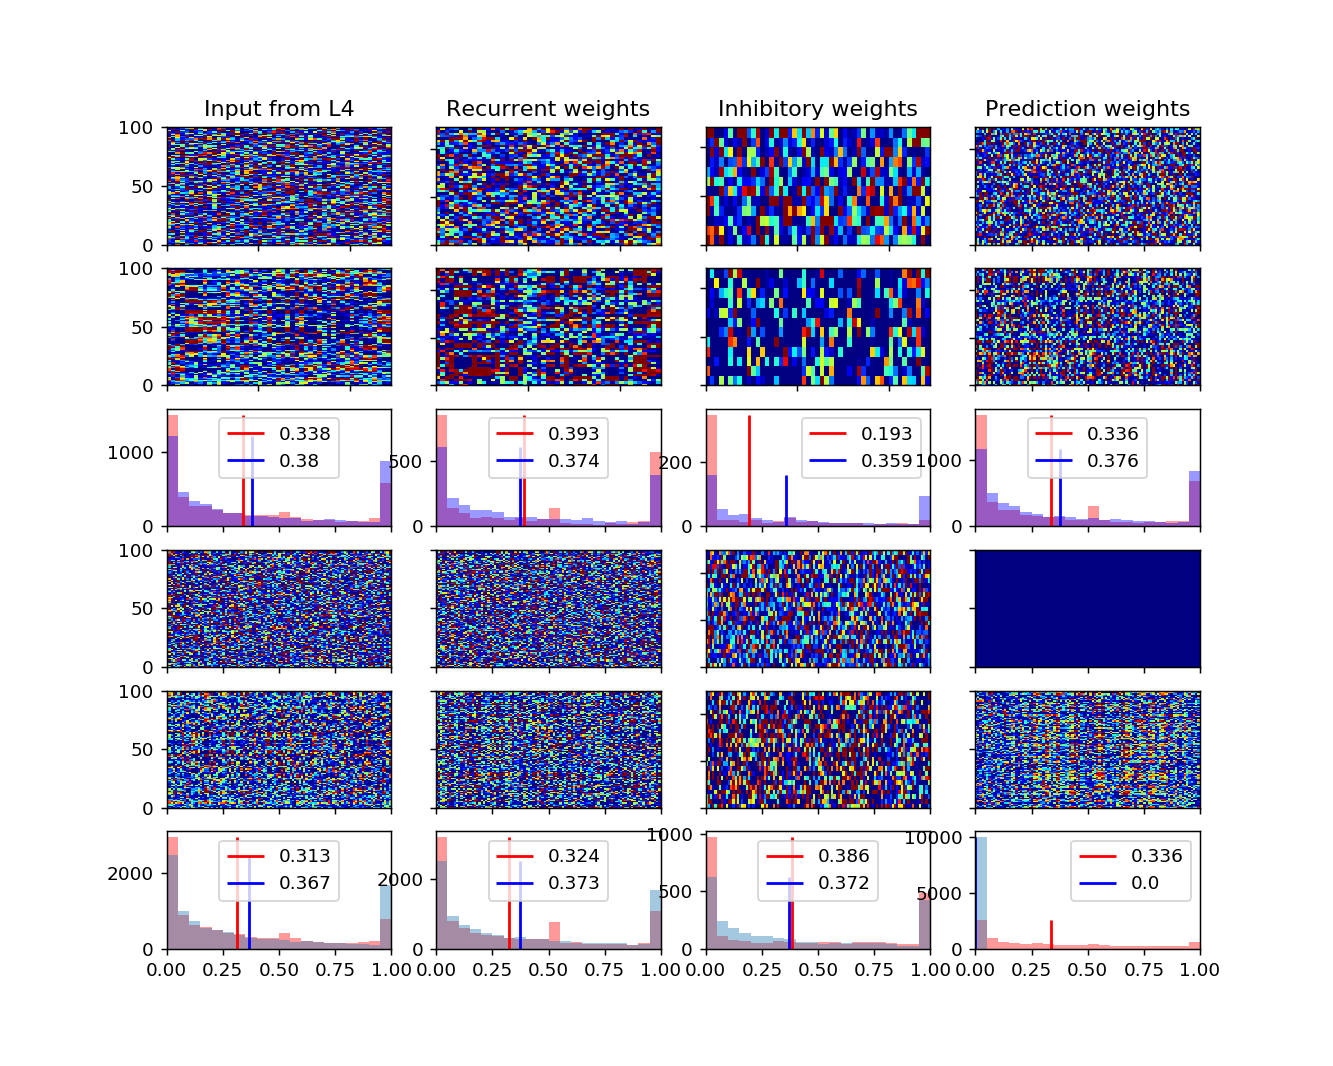

<IPython.core.display.Javascript object>


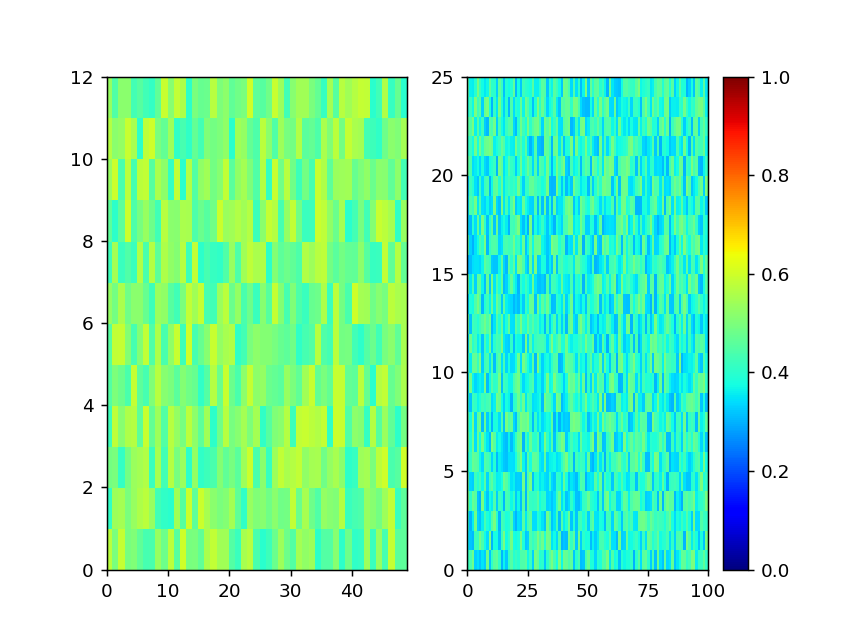

In [5]:
# Weight initialization & after training
# load data
inp = 100
N_c = 49
N_p = 100
cm = plt.cm.get_cmap('jet')
dims = {'inp': (inp,N_c),
        'rec_c': (N_c,N_c),
        'inh_wta_c': (int(N_c/4),N_c),
        'inp_p': (N_c,N_p),
        'error': (inp, N_p),
        'rec_p': (N_p, N_p),
        'inh_wta_p': (int(N_p/4), N_p),
        'pred': (N_p, inp)}

name='inp'
L4_L23_init = np.load(data_dir + '{}/{}_{}_{}_weights_init.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='rec_c'
L23_L23_init = np.load(data_dir + '{}/{}_{}_{}_weights_init.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='inh_wta_c'
Inh_L23_init = np.load(data_dir + '{}/{}_{}_{}_weights_init.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='inp_p'
L23_L6_init = np.load(data_dir + '{}/{}_{}_{}_weights_init.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='error'
L4_L6_init = np.load(data_dir + '{}/{}_{}_{}_weights_init.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='rec_p'
L6_L6_init = np.load(data_dir + '{}/{}_{}_{}_weights_init.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='inh_wta_p'
Inh_L6_init = np.load(data_dir + '{}/{}_{}_{}_weights_init.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='pred'
L6_L4_init = np.load(data_dir + '{}/{}_{}_{}_weights_init.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])



name='inp'
L4_L23 = np.load(data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='rec_c'
L23_L23 = np.load(data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='inh_wta_c'
Inh_L23 = np.load(data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='inp_p'
L23_L6 = np.load(data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='error'
L4_L6 = np.load(data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='rec_p'
L6_L6 = np.load(data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='inh_wta_p'
Inh_L6 = np.load(data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])
name='pred'
L6_L4 = np.load(data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, date[:5], timestamp, name)).reshape(dims[name])

f, axarr = plt.subplots(6,4, figsize=(10,8))
# INPUT
axarr[0,0].pcolor(L4_L23_init.reshape(dims['inp']), vmin=0, vmax=1, cmap=cm)
axarr[0,0].set_title('Input from L4')
axarr[0,0].xaxis.set_ticklabels([])
axarr[1,0].pcolor(L4_L23.reshape(dims['inp']), vmin=0, vmax=1, cmap=cm)
axarr[1,0].xaxis.set_ticklabels([])
axarr[2,0].hist(L4_L23.flatten(), bins=20, alpha=0.4, color='r')
axarr[2,0].vlines(x=np.mean(L4_L23), ymin=0, ymax=np.max(np.histogram(L4_L23.flatten(), bins=20)[0]), color='r', label='{}'.format(np.round(np.mean(L4_L23), 3)))
axarr[2,0].hist(L4_L23_init.flatten(), bins=20, alpha=0.4, color='b')
axarr[2,0].vlines(x=np.mean(L4_L23_init), ymin=0, ymax=np.max(np.histogram(L4_L23_init.flatten(), bins=20)[0]), color='b', label='{}'.format(np.round(np.mean(L4_L23_init), 3)))
axarr[2,0].set_xlim(0,1)
axarr[2,0].xaxis.set_ticklabels([])
axarr[2,0].legend()
# REC COMPRESSION
axarr[0,1].pcolor(L23_L23_init.reshape(dims['rec_c']), vmin=0, vmax=1, cmap=cm)
axarr[0,1].set_title('Recurrent weights')
axarr[0,1].xaxis.set_ticklabels([])
axarr[0,1].yaxis.set_ticklabels([])
axarr[1,1].pcolor(L23_L23.reshape(dims['rec_c']), vmin=0, vmax=1, cmap=cm)
axarr[1,1].xaxis.set_ticklabels([])
axarr[1,1].yaxis.set_ticklabels([])
axarr[2,1].hist(L23_L23.flatten(), bins=20, alpha=0.4, color='r')
axarr[2,1].vlines(x=np.mean(L23_L23), ymin=0, ymax=np.max(np.histogram(L23_L23.flatten(), bins=20)[0]), color='r', label='{}'.format(np.round(np.mean(L23_L23), 3)))
axarr[2,1].hist(L23_L23_init.flatten(), bins=20, alpha=0.4, color='b')
axarr[2,1].vlines(x=np.mean(L23_L23_init), ymin=0, ymax=np.max(np.histogram(L23_L23_init.flatten(), bins=20)[0]), color='b', label='{}'.format(np.round(np.mean(L23_L23_init), 3)))
axarr[2,1].set_xlim(0,1)
axarr[2,1].xaxis.set_ticklabels([])
axarr[2,1].legend()
# INH COMPRESSION
axarr[0,2].pcolor(Inh_L23_init.reshape(dims['inh_wta_c']), vmin=0, vmax=1, cmap=cm)
axarr[0,2].set_title('Inhibitory weights')
axarr[0,2].xaxis.set_ticklabels([])
axarr[0,2].yaxis.set_ticklabels([])
axarr[1,2].pcolor(Inh_L23.reshape(dims['inh_wta_c']), vmin=0, vmax=1, cmap=cm)
axarr[1,2].xaxis.set_ticklabels([])
axarr[1,2].yaxis.set_ticklabels([])
axarr[2,2].hist(Inh_L23.flatten(), bins=20, alpha=0.4, color='r')
axarr[2,2].vlines(x=np.mean(Inh_L23), ymin=0, ymax=np.max(np.histogram(Inh_L23.flatten(), bins=20)[0]), color='r', label='{}'.format(np.round(np.mean(Inh_L23), 3)))
axarr[2,2].hist(Inh_L23_init.flatten(), bins=20, alpha=0.4, color='b')
axarr[2,2].vlines(x=np.mean(Inh_L23_init), ymin=0, ymax=np.max(np.histogram(Inh_L23_init.flatten(), bins=20)[0]), color='b', label='{}'.format(np.round(np.mean(Inh_L23_init), 3)))
axarr[2,2].set_xlim(0,1)
axarr[2,2].xaxis.set_ticklabels([])
axarr[2,2].legend()
# COMPRESSION - PREDICTION
axarr[0,3].pcolor(L23_L6_init.reshape(dims['inp_p']), vmin=0, vmax=1, cmap=cm)
axarr[0,3].set_title('Prediction weights')
axarr[0,3].xaxis.set_ticklabels([])
axarr[0,3].yaxis.set_ticklabels([])
axarr[1,3].pcolor(L23_L6.reshape(dims['inp_p']), vmin=0, vmax=1, cmap=cm)
axarr[1,3].xaxis.set_ticklabels([])
axarr[1,3].yaxis.set_ticklabels([])
axarr[2,3].hist(L23_L6.flatten(), bins=20, alpha=0.4, color='r')
axarr[2,3].vlines(x=np.mean(L23_L6), ymin=0, ymax=np.max(np.histogram(L23_L6.flatten(), bins=20)[0]), color='r', label='{}'.format(np.round(np.mean(L23_L6), 3)))
axarr[2,3].hist(L23_L6_init.flatten(), bins=20, alpha=0.4, color='b')
axarr[2,3].vlines(x=np.mean(L23_L6_init), ymin=0, ymax=np.max(np.histogram(L23_L6_init.flatten(), bins=20)[0]), color='b', label='{}'.format(np.round(np.mean(L23_L6_init), 3)))
axarr[2,3].set_xlim(0,1)
axarr[2,3].xaxis.set_ticklabels([])
axarr[2,3].legend()


# ERROR
axarr[3,0].pcolor(L4_L6_init.reshape(dims['error']), vmin=0, vmax=1, cmap=cm)
axarr[3,0].xaxis.set_ticklabels([])
axarr[4,0].pcolor(L4_L6.reshape(dims['error']), vmin=0, vmax=1, cmap=cm)
axarr[4,0].xaxis.set_ticklabels([])
axarr[5,0].hist(L4_L6.flatten(), bins=20, alpha=0.4, color='r')
axarr[5,0].vlines(x=np.mean(L4_L6), ymin=0, ymax=np.max(np.histogram(L4_L6.flatten(), bins=20)[0]), color='r', label='{}'.format(np.round(np.mean(L4_L6), 3)))
axarr[5,0].hist(L4_L6_init.flatten(), bins=20, alpha=0.4)
axarr[5,0].vlines(x=np.mean(L4_L6_init), ymin=0, ymax=np.max(np.histogram(L4_L6_init.flatten(), bins=20)[0]), color='b', label='{}'.format(np.round(np.mean(L4_L6_init), 3)))
axarr[5,0].set_xlim(0,1)
axarr[5,0].legend()
# REC PREDICTION
axarr[3,1].pcolor(L6_L6_init.reshape(dims['rec_p']), vmin=0, vmax=1, cmap=cm)
axarr[3,1].xaxis.set_ticklabels([])
axarr[3,1].yaxis.set_ticklabels([])
axarr[4,1].pcolor(L6_L6.reshape(dims['rec_p']), vmin=0, vmax=1, cmap=cm)
axarr[4,1].xaxis.set_ticklabels([])
axarr[4,1].yaxis.set_ticklabels([])
axarr[5,1].hist(L6_L6.flatten(), bins=20, alpha=0.4, color='r')
axarr[5,1].vlines(x=np.mean(L6_L6), ymin=0, ymax=np.max(np.histogram(L6_L6.flatten(), bins=20)[0]), color='r', label='{}'.format(np.round(np.mean(L6_L6), 3)))
axarr[5,1].hist(L6_L6_init.flatten(), bins=20, alpha=0.4)
axarr[5,1].vlines(x=np.mean(L6_L6_init), ymin=0, ymax=np.max(np.histogram(L6_L6_init.flatten(), bins=20)[0]), color='b', label='{}'.format(np.round(np.mean(L6_L6_init), 3)))
axarr[5,1].set_xlim(0,1)
axarr[5,1].legend()
# INH PREDICTION
axarr[3,2].pcolor(Inh_L6_init.reshape(dims['inh_wta_p']), vmin=0, vmax=1, cmap=cm)
axarr[3,2].xaxis.set_ticklabels([])
axarr[3,2].yaxis.set_ticklabels([])
axarr[4,2].pcolor(Inh_L6.reshape(dims['inh_wta_p']), vmin=0, vmax=1, cmap=cm)
axarr[4,2].xaxis.set_ticklabels([])
axarr[4,2].yaxis.set_ticklabels([])
axarr[5,2].hist(Inh_L6.flatten(), bins=20, alpha=0.4, color='r')
axarr[5,2].vlines(x=np.mean(Inh_L6), ymin=0, ymax=np.max(np.histogram(Inh_L6.flatten(), bins=20)[0]), color='r', label='{}'.format(np.round(np.mean(Inh_L6), 3)))
axarr[5,2].hist(Inh_L6_init.flatten(), bins=20, alpha=0.4)
axarr[5,2].vlines(x=np.mean(Inh_L6_init), ymin=0, ymax=np.max(np.histogram(Inh_L6_init.flatten(), bins=20)[0]), color='b', label='{}'.format(np.round(np.mean(Inh_L6_init), 3)))
axarr[5,2].set_xlim(0,1)
axarr[5,2].legend()
# PREDICTION - INPUT
axarr[3,3].pcolor(L6_L4_init.reshape(dims['pred']), vmin=0, vmax=1, cmap=cm)
axarr[3,3].xaxis.set_ticklabels([])
axarr[3,3].yaxis.set_ticklabels([])
axarr[4,3].pcolor(L6_L4.reshape(dims['pred']), vmin=0, vmax=1, cmap=cm)
axarr[4,3].xaxis.set_ticklabels([])
axarr[4,3].yaxis.set_ticklabels([])
axarr[5,3].hist(L6_L4.flatten(), bins=20, alpha=0.4, color='r')
axarr[5,3].vlines(x=np.mean(L6_L4), ymin=0, ymax=np.max(np.histogram(L6_L4.flatten(), bins=20)[0]), color='r', label='{}'.format(np.round(np.mean(L6_L4), 3)))
axarr[5,3].hist(L6_L4_init.flatten(), bins=20, alpha=0.4)
axarr[5,3].vlines(x=np.mean(L6_L4_init), ymin=0, ymax=np.max(np.histogram(L6_L4_init.flatten(), bins=20)[0]), color='b', label='{}'.format(np.round(np.mean(L6_L4_init), 3)))
axarr[5,3].set_xlim(0,1)
axarr[5,3].legend()
                  
L23_variance_th = np.load(data_dir + '{}/{}_{}_c_variance_th.npy'.format(date, date[:5], timestamp)).reshape(dims['inh_wta_c'])
L6_variance_th = np.load(data_dir + '{}/{}_{}_p_variance_th.npy'.format(date, date[:5], timestamp)).reshape(dims['inh_wta_p'])

f, axarr = plt.subplots(1,2)
axarr[0].pcolor(L23_variance_th, vmin=0, vmax=1, cmap=cm)
x = axarr[1].pcolor(L6_variance_th, vmin=0, vmax=1, cmap=cm)
plt.colorbar(x, ax=axarr[1])
# plt.subplots_adjust(wspace=0.3, hspace=0.3)
                  
# plt.show()

In [7]:
# get data
name = 'state_mon_c_activity_proxy'
activity_proxy_c_data = np.load(data_dir + '{}/{}_{}_{}.npy'.format(date, date[:5], timestamp, name))
name = 'state_mon_c_norm_activity_proxy'
norm_activity_proxy_c_data = np.load(data_dir + '{}/{}_{}_{}.npy'.format(date, date[:5], timestamp, name))

name = 'state_mon_p_activity_proxy'
activity_proxy_p_data = np.load(data_dir + '{}/{}_{}_{}.npy'.format(date, date[:5], timestamp, name))
name = 'state_mon_p_norm_activity_proxy'
norm_activity_proxy_p_data = np.load(data_dir + '{}/{}_{}_{}.npy'.format(date, date[:5], timestamp, name))


# Set layout
app = QtGui.QApplication.instance()
if app is None:
    app = QtGui.QApplication(sys.argv)
else:
    print('QApplication instance already exists: %s' % str(app))

sort_rasterplot = True
win = pg.GraphicsWindow(title="Variance of the membrane potential")
win.resize(1024, 768)
activity_proxy_c = win.addPlot(title="Activity proxy L23")
activity_proxy_p = win.addPlot(title='Activity proxy L6')
win.nextRow()
norm_activity_proxy_c = win.addPlot(title="Normalized activity proxy L23")
norm_activity_proxy_p = win.addPlot(title='Normalized activity proxy L6')

region = pg.LinearRegionItem()
region.setZValue(10)

activity_proxy_c.addItem(region, ignoreBounds=True)

for ii in range(np.shape(activity_proxy_c_data)[0]):
    activity_proxy_c.plot(activity_proxy_c_data[ii, :] / pA)
    norm_activity_proxy_c.plot(norm_activity_proxy_c_data[ii, :])
    
for ii in range(np.shape(activity_proxy_p_data)[0]):
    activity_proxy_p.plot(activity_proxy_p_data[ii, :] / pA)
    norm_activity_proxy_p.plot(norm_activity_proxy_p_data[ii, :])
    
def update():
    region.setZValue(10)
    minX, maxX = region.getRegion()
    activity_proxy_p.setXRange(minX, maxX, padding=0) 
    norm_activity_proxy_c.setXRange(minX, maxX, padding=0) 
    norm_activity_proxy_p.setXRange(minX, maxX, padding=0) 

region.sigRegionChanged.connect(update)

def updateRegion(window, viewRange):
    rgn = viewRange[0]
    region.setRegion(rgn)

activity_proxy_p.sigRangeChanged.connect(updateRegion)
norm_activity_proxy_c.sigRangeChanged.connect(updateRegion)
norm_activity_proxy_p.sigRangeChanged.connect(updateRegion)

app.exec_()

QApplication instance already exists: <PyQt5.QtWidgets.QApplication object at 0x7f9b38aff798>


0

In [ ]:
app.exec_()

(4900, 216)


<IPython.core.display.Javascript object>


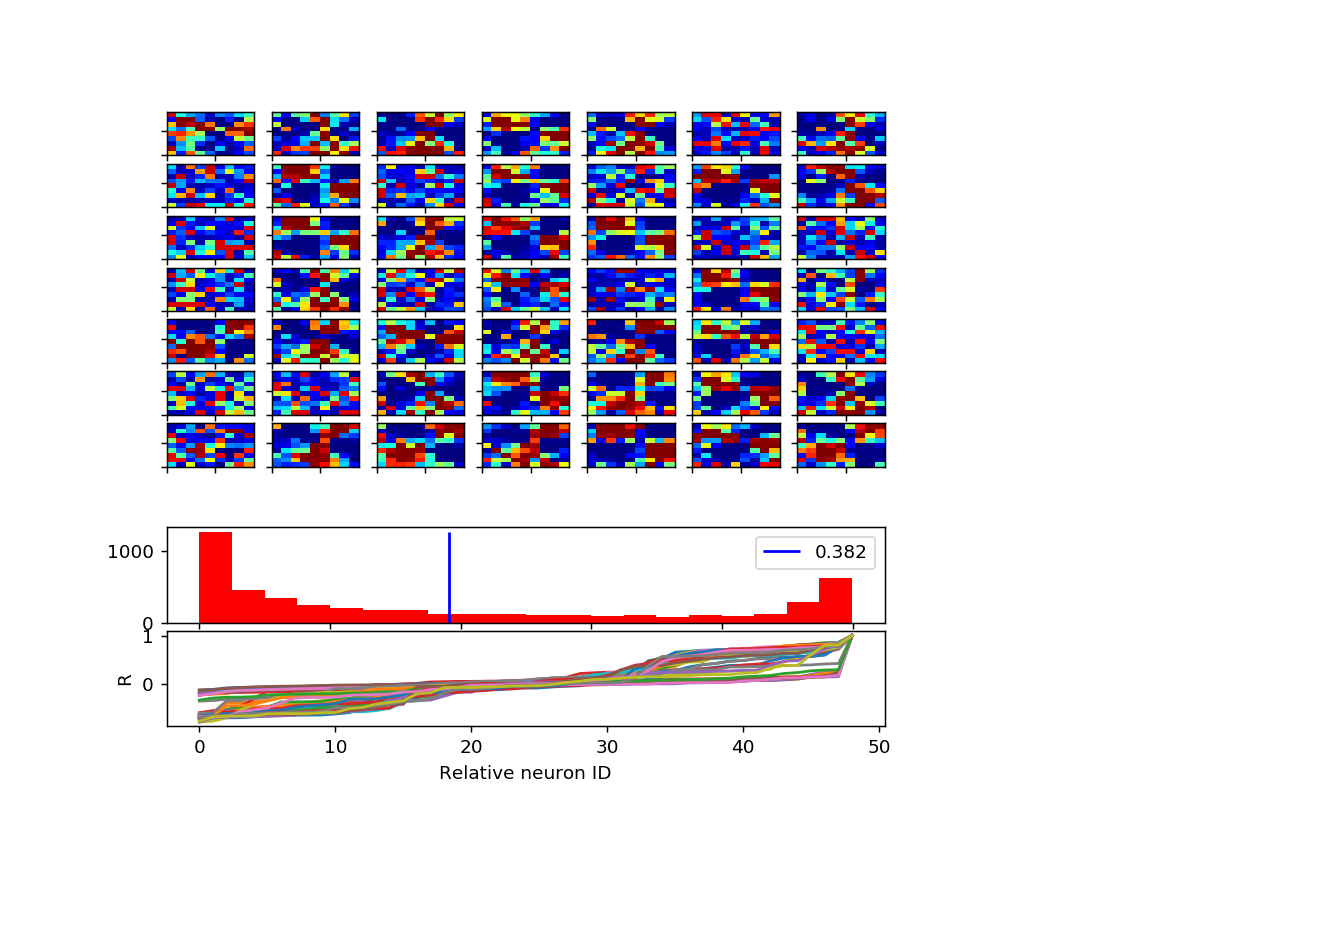

In [83]:
# name='inp'
# L4_L23_init = np.load(data_dir + '{}/{}_{}_{}_weights_init.npy'.format(date, date[:5], timestamp, name)).reshape(100,49)
# plt.figure(0, figsize=(10,8))
# plot_receptive_fields(L4_L23_init)
# plt.draw()

gif_dir = data_dir + '{}/{}_{}_gif'.format(date, date[:5], timestamp)
if not os.path.exists(gif_dir):
        os.mkdir(gif_dir + "/")
dims = (100,49)
name = 'state_mon_c_w_plast'
data = np.load(data_dir + '{}/{}_{}_{}.npy'.format(date, date[:5], timestamp, name))
print(np.shape(data))
for t in range(np.shape(data)[1]):
    plt.figure(0, figsize=(10,7))
    current_weights = np.reshape(data[:, t], dims)
    plot_receptive_fields_debug(current_weights)
    plt.savefig(gif_dir + '/{}.jpeg'.format(t), 
                dpi=100, orientation='landscape', 
                bbox_inches='tight', pad_inches=0.5)
#     plt.close(t)
    

In [ ]:
### plt.plot(state_mon_i_pred.Ipred)
plt.ylim([0,1.1])
# plot_adjacency_matrix(prediction_connection, variable="Ipred_plast")

# Rasterplots to check periodicity

In [4]:

app = QtGui.QApplication.instance()
if app is None:
    app = QtGui.QApplication(sys.argv)
else:
    print('QApplication instance already exists: %s' % str(app))

sort_rasterplot = True
win = pg.GraphicsWindow(title="Rasterplot")
win.resize(1024, 768)
rasterPlot_c = win.addPlot(title="Rasterplot compression")
rasterPlot_p = win.addPlot(title='Rasterplot prediction')
win.nextRow()
detailed_rasterplot_c = win.addPlot(title="Detailed rasterplot compression")
detailed_rasterplot_p = win.addPlot(title="Detailed rasterplot prediction")
win.nextRow()
detailed_rasterplot_c_i = win.addPlot(title="Detailed rasterplot compression inhibition")
detailed_rasterplot_p_i = win.addPlot(title="Detailed rasterplot prediction inhibition")

detailed_rasterplot_c.showGrid(x=True, y=True)
detailed_rasterplot_p.showGrid(x=True, y=True)
detailed_rasterplot_c_i.showGrid(x=True, y=True)
detailed_rasterplot_p_i.showGrid(x=True, y=True)

region = pg.LinearRegionItem()
region.setZValue(10)

rasterPlot_c.addItem(region, ignoreBounds=True)
rasterPlot_p.addItem(region, ignoreBounds=True)

# Load data
data_dir = '/home/matteo/Documents/Repositories/OCTA/results/'
# data_dir = '/home/schlowmo/Documents/OCTA/results/'
date = '13_06_2019'
timestamp = '17_45'
filename = data_dir + '{}/{}_{}_spikemon_compressionWTA.npy'.format(date, 
                                                                    date[:5], 
                                                                    timestamp)

monitor = load_monitor(filename)
# name='inp'
name = 'rec_c'
filename_weights = data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, 
                                                                    date[:5], 
                                                                    timestamp,
                                                                    name)

if sort_rasterplot:
    s = SortMatrix(nrows=49, ncols=49, filename=filename_weights, axis=1)
    monitor.i = np.asarray([np.where(np.asarray(s.permutation) == int(i))[0][0] for i in monitor.i])


plot_spikemon_qt(monitor=monitor, window=detailed_rasterplot_c, 
                 num_neurons=np.max(monitor.i), unit=ms)
plot_spikemon_qt(monitor=monitor, window=rasterPlot_c, 
                 num_neurons=np.max(monitor.i), unit=ms)


# filename = data_dir + '{}/{}_{}_spikemon_compressionWTA_i.npy'.format(date,
filename = data_dir + '{}/{}_{}_spikemon_predictionWTA.npy'.format(date,
                                                                     date[:5],
                                                                     timestamp)

monitor = load_monitor(filename)
# name='error'
# name = 'pred'
# name='rec_p'
name='inp_p'
filename_weights = data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, 
                                                                    date[:5], 
                                                                    timestamp,
                                                                    name)


# monitor = load_monitor(filename=data_dir + '05_04_2018/05_04_19_16_spike_mon_input.npy')
if sort_rasterplot:
    s = SortMatrix(nrows=49, ncols=100, filename=filename_weights, axis=1)
    monitor.i = np.asarray([np.where(np.asarray(s.permutation) == int(i))[0][0] for i in monitor.i])


plot_spikemon_qt(monitor=monitor, window=rasterPlot_p, 
                 num_neurons=np.max(monitor.i), unit=ms)
plot_spikemon_qt(monitor=monitor, window=detailed_rasterplot_p, 
                 num_neurons=np.max(monitor.i), unit=ms)

filename = data_dir + '{}/{}_{}_spikemon_predictionWTA_i.npy'.format(date,
                                                                      date[:5], 
                                                                      timestamp,
                                                                      name)
monitor = load_monitor(filename)
plot_spikemon_qt(monitor=monitor, window=detailed_rasterplot_p_i, 
                 num_neurons=np.max(monitor.i), unit=ms)

filename = data_dir + '{}/{}_{}_spikemon_compressionWTA_i.npy'.format(date,
                                                                      date[:5], 
                                                                      timestamp,
                                                                      name)
monitor = load_monitor(filename)
plot_spikemon_qt(monitor=monitor, window=detailed_rasterplot_c_i, 
                 num_neurons=np.max(monitor.i), unit=ms)


def update():
    region.setZValue(10)
    minX, maxX = region.getRegion()
    detailed_rasterplot_c.setXRange(minX, maxX, padding=0) 
    detailed_rasterplot_p.setXRange(minX, maxX, padding=0) 
    detailed_rasterplot_c_i.setXRange(minX, maxX, padding=0) 
    detailed_rasterplot_p_i.setXRange(minX, maxX, padding=0) 

region.sigRegionChanged.connect(update)

def updateRegion(window, viewRange):
    rgn = viewRange[0]
    region.setRegion(rgn)

detailed_rasterplot_c.sigRangeChanged.connect(updateRegion)
detailed_rasterplot_p.sigRangeChanged.connect(updateRegion)
detailed_rasterplot_c_i.sigRangeChanged.connect(updateRegion)
detailed_rasterplot_p_i.sigRangeChanged.connect(updateRegion)

region.setRegion([700, 1420])

app.exec_()

QApplication instance already exists: <PyQt5.QtWidgets.QApplication object at 0x7f429b6a0558>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]
[3.25135772        inf 3.0622717  3.53875091 3.47499097 3.16831563
 3.68574181 3.49083568 3.243335   3.60307965 3.61067996 3.32286283
 3.60774253 3.69286293 3.48095784 3.6742578  3.67651172 3.44939077
 3.08938199 3.30242424 3.32165672 3.09006056 3.07993763 3.63300329
 2.94197183 3.35691874 3.21609196 3.00995063 2.98671054 3.26874632
 3.50069567 3.33864406 3.59824733 3.67898642 3.35173437 3.51312472
 3.09600154 3.3436487  3.01950873 3.20668306 2.68042321 3.30321884
 3.35402221 3.39532024 3.53265391 3.05468088 2.52157068 3.43238629
 3.46336509]
[3.25135772        inf 3.0622717  3.53875091 3.47499097 3.16831563
 3.68574181 3.49083568 3.243335   3.60307965 3.61067996 3.32286283
 3.60774253 3.69286293 

 2.84231395 2.94535463 2.53691204 2.79269278]
[3.19660444        inf 3.04261361 2.56780318 2.82432567 2.93924451
 2.94725669 3.36272779 2.77923305 3.39239784 2.67824176 2.99579515
 3.11788579 3.04344385 3.04732695 2.68621863 3.02739234 3.18497823
 2.65772454 2.59193406 2.82785593 3.25030287 2.41337171 3.10425068
 3.12781851 2.75086769 2.61044255 2.70884308 2.59887996 2.94572308
 2.69818181 2.78609905 2.48689247 2.96995077 2.6764012  3.23946801
 2.93384789 2.99286332 2.85385955 3.01641763 2.71174528 2.56326296
 2.82522476 2.83957511 3.25458186 2.80019638 3.21646896 3.13640753
 3.28784275 2.22971372 3.02930264 3.35932788 2.45282395 2.75940367
 2.60400432 3.00069789 2.87680981 3.2823054  3.13540216 3.46896615
 3.31330394 2.61249262 2.59001239 2.90938354 2.99891842 3.18177417
 3.39124456 2.5187048  2.99982477 3.03014145 2.53693462 2.84848687
 2.78964219 3.14032792 2.52609342 2.76494228 3.16752549 2.67058921
 2.57366536 2.81939175 2.99912896 2.45921774 2.60686743 3.13383497
 2.60229514 2.80

0

In [9]:
app.exec_()

0

In [ ]:
print(len(predictionWTA.Groups['synWTAInh1e'])/(100*25))
print(predictionWTA.Groups['synWTAInh1e'].weight)

In [ ]:
fig = plt.figure()
plt.plot(state_mon_i_mem_var.t / ms, state_mon_i_mem_var.normalized_Imem_var[5, :])

# plt.plot(state_mon_i_mem_var.normalized_Imem_var)
plt.draw()
plt.show()

# Plotting input adjacency matrix

In [6]:
synapse_group = compressionWTA.Groups['synInpWTA1e']
# synapse_group = predictionWTA.Groups['synInpWTA1e']
# synapse_group = error_connection


load_from_recording = True
data_dir = '/home/schlowmo/Repositories/OCTA/results/'
date = '01_11_2018'
timestamp = '14_52'
name = 'inp'
filename_weights = data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, 
                                                                    date[:5], 
                                                                    timestamp,
                                                                    name)
weight_matrix = load_weights(filename=filename_weights, nrows=100, ncols=49)
if load_from_recording:
    synapse_group.w_plast = weight_matrix.flatten()

plot_adjacency_matrix(synapse_group=synapse_group)

name = '{}_{}_plastic'.format(synapse_group.source.name, synapse_group.target.name)
if weight_decay == 'global':
    name = '{}_{}_plastic_global_w_decay'.format(synapse_group.source.name, synapse_group.target.name)
elif weight_decay == 'local':
    name = '{}_{}_plastic_local_w_decay'.format(synapse_group.source.name, synapse_group.target.name)
if load_from_recording:
    plt.savefig('/home/schlowmo/Repositories/OCTA/plots/adjacency_matrix_{}_{}.pdf'.format(name, date[:5] + '_' + timestamp), 
                dpi=600, orientation='landscape', 
                bbox_inches='tight', pad_inches=0.5)
else:
    plt.savefig('/home/schlowmo/Repositories/OCTA/plots/adjacency_matrix_{}_{}.pdf'.format(name, time.strftime("%d_%m_%H_%M")), 
                dpi=600, orientation='landscape', 
                bbox_inches='tight', pad_inches=0.5)

NameError: name 'compressionWTA' is not defined

# Plotting recurrent adjacency matrix


In [ ]:
synapse_group = compressionWTA.Groups['synWTAWTA1e']

load_from_recording = True
data_dir = '/home/schlowmo/Repositories/OCTA/results/'
date = '25_07_2018'
timestamp = '10_29'
name = 'rec_c'
filename_weights = data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, 
                                                                    date[:5], 
                                                                    timestamp,
                                                                    name)
weight_matrix = load_weights(filename=filename_weights, nrows=49)
if load_from_recording:
    synapse_group.w_plast = weight_matrix.flatten()

plot_adjacency_matrix(synapse_group=synapse_group)
if weight_decay == 'global':
    name = '{}_{}_plastic_global_w_decay'.format(synapse_group.source.name, synapse_group.target.name)
elif weight_decay == 'local':
    name = '{}_{}_plastic_local_w_decay'.format(synapse_group.source.name, synapse_group.target.name)
# plt.savefig('/home/schlowmo/Repositories/OCTA/plots/adjacency_matrix_{}_{}.pdf'.format(name, 
#                                                                                               time.strftime("%d_%m_%H_%M")), 
#             dpi=600, orientation='landscape', 
#             bbox_inches='tight', pad_inches=0.5)

# Plotting IE/EI adjacency matrix

In [ ]:
synapse_group = compressionWTA.Groups['synWTAInh1e']

plot_adjacency_matrix(synapse_group=synapse_group)
if weight_decay == 'global':
    name = '{}_{}_plastic_global_w_decay'.format(synapse_group.source.name, synapse_group.target.name)
elif weight_decay == 'local':
    name = '{}_{}_plastic_local_w_decay'.format(synapse_group.source.name, synapse_group,target.name)

###

synapse_group = compressionWTA.Groups['synInhWTA1i']

plot_adjacency_matrix(synapse_group=synapse_group)

w_diff = inh_w_before_learning.flatten() - synapse_group.w_plast
# print(len(w_diff))
plt.matshow(np.reshape(w_diff, (12, -1)))
plt.colorbar()
plt.show()

if weight_decay == 'global':
    name = '{}_{}_plastic_global_w_decay'.format(synapse_group.source.name, synapse_group.target.name)
elif weight_decay == 'local':
    name = '{}_{}_plastic_local_w_decay'.format(synapse_group.source.name, synapse_group.target.name)

# Plot feature maps

<IPython.core.display.Javascript object>


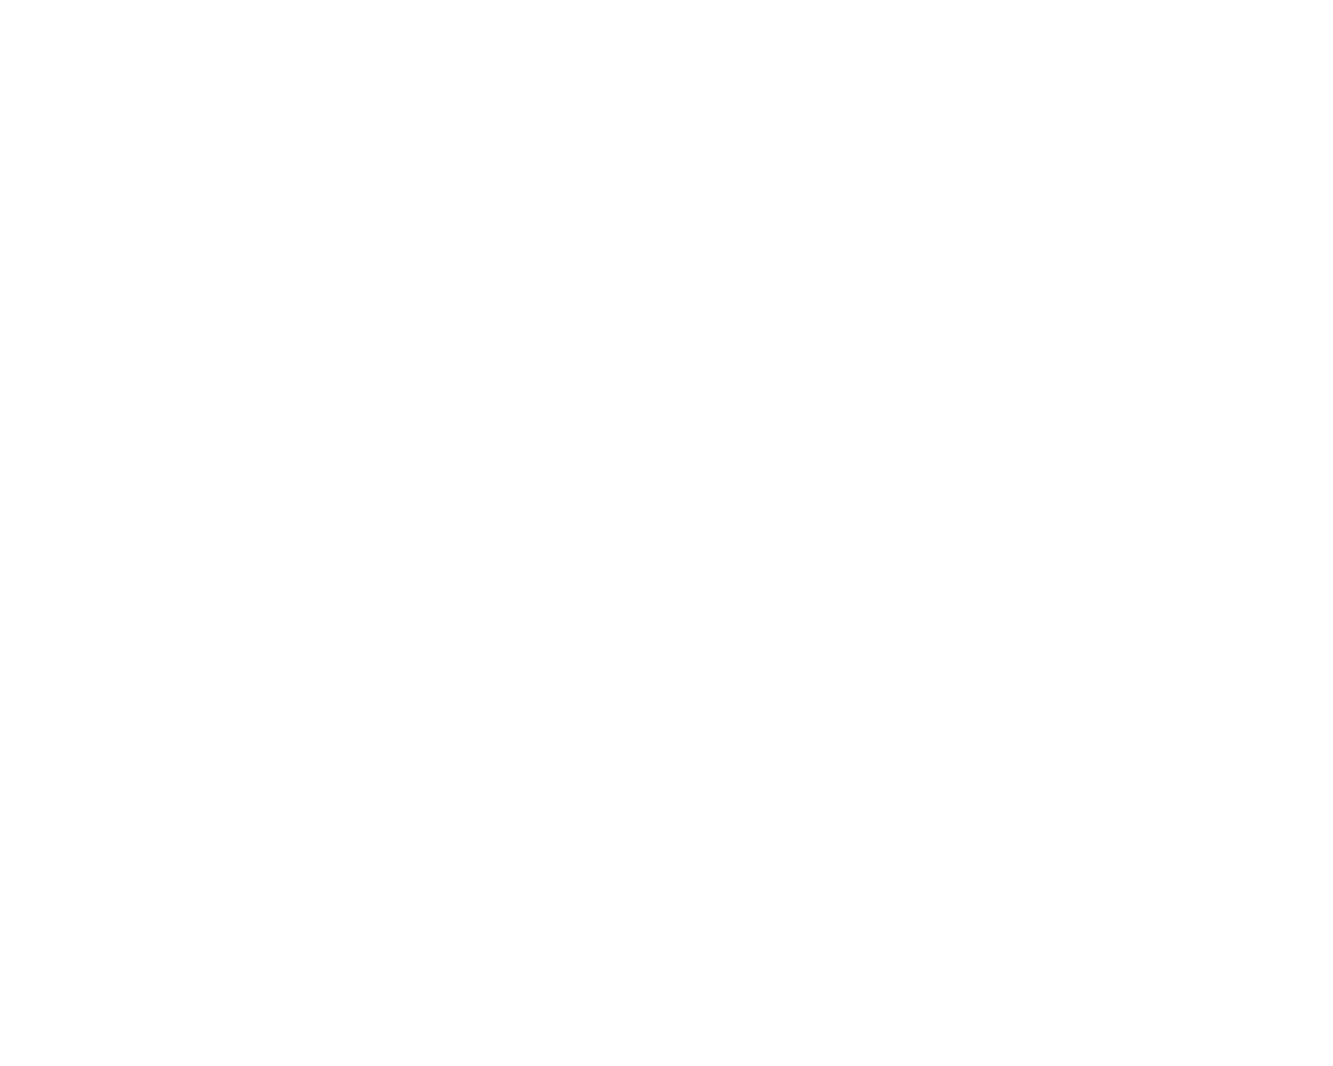

<IPython.core.display.Javascript object>


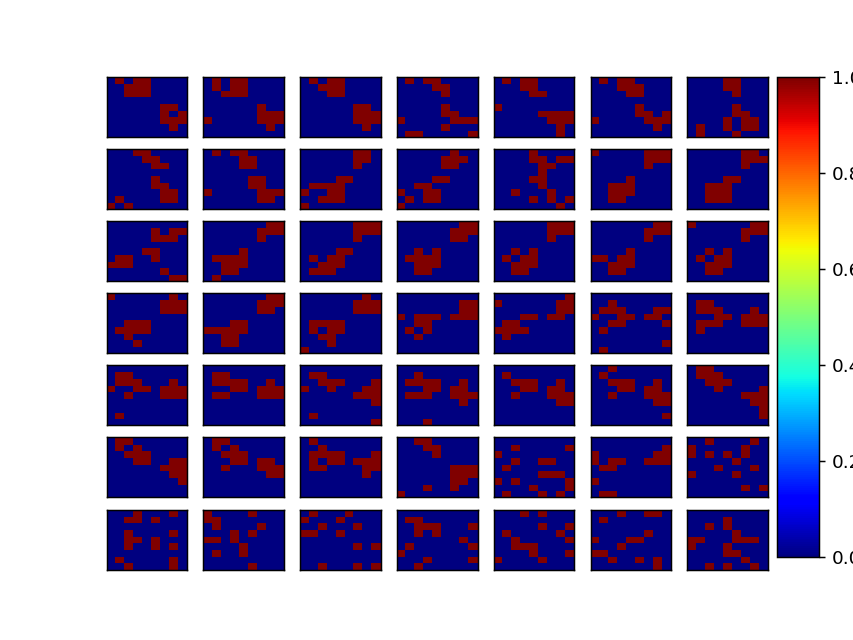

In [7]:
def quantize_weights_number(weights, n_weights=5):
    quantized_weights = np.zeros(np.shape(weights))
    for target in range(np.shape(weights)[1]):
        sorted_indices = np.argsort(weights[:, target])
        quantized_weights[sorted_indices[:n_weights], target] = 1
    return quantized_weights

# synapse_group = compressionWTA.Groups['synInpWTA1e']
# synapse_group = compressionWTA.Groups['synInhWTA1i']
# synapse_groups = compressionWTA.Groups['synWTAInh1e']
# synapse_group = predictionWTA.Groups['synInpWTA1e']
# synapse_group = compressionWTA.Groups['synWTAWTA1e']
# synapse_group = error_connection
load_from_recording = True
data_dir = '/home/schlowmo/Repositories/OCTA/results/'
date = '01_11_2018'
timestamp = '14_52'
# name = 'error'
name = 'inp'
filename_weights = data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, 
                                                                    date[:5], 
                                                                    timestamp,
                                                                    name)
weight_matrix = load_weights(filename=filename_weights, nrows=100)
# if load_from_recording:
#     synapse_group.w_plast = weight_matrix.flatten()

# cInd = np.argsort(weight_matrix)[:20]
# weight_matrix[cInd] = 1
# weight_matrix[weight_matrix!=1] = 0
weight_matrix = np.reshape(weight_matrix, (100,49))
matrix_to_sort = data_dir + '{}/{}_{}_{}.npy'.format(date, date[:5], timestamp, 'rec_c_weights_last')
s = SortMatrix(nrows=49, ncols=49, filename=matrix_to_sort, axis=1)
weight_matrix = quantize_weights_number(weight_matrix, n_weights=20)
plt.figure(figsize=(10,8))
plot_receptive_fields(weight_matrix[:, s.permutation])


# name = '{}_{}_plastic'.format(synapse_group.source.name, synapse_group.target.name)
# if weight_decay == 'global':
#     name = '{}_{}_plastic_global_w_decay'.format(synapse_group.source.name, synapse_group.target.name)
# elif weight_decay == 'local':
#     name = '{}_{}_plastic_local_w_decay'.format(synapse_group.source.name, synapse_group.target.name)

        
# if load_from_recording:
#     plt.savefig('/home/schlowmo/Repositories/OCTA/plots/receptive_fields_{}_{}.pdf'.format(name, date[:5] + '_' + timestamp), 
#                 dpi=600, orientation='landscape', 
#                 bbox_inches='tight', pad_inches=0.5)
# else:
#     plt.savefig('/home/schlowmo/Repositories/OCTA/plots/receptive_fields_{}_{}.pdf'.format(name, time.strftime("%d_%m_%H_%M")), 
#                 dpi=600, orientation='landscape', 
#                 bbox_inches='tight', pad_inches=0.5)
name = 'quantized'
plot_dir = '/home/schlowmo/Documents/OCTA/Thesis'
plt.savefig(plot_dir + '/{}.pdf'.format(name), 
            dpi=600, orientation='landscape', 
            bbox_inches='tight', pad_inches=0.5)
plt.show()


# Computing similarties to sort matrices

<IPython.core.display.Javascript object>


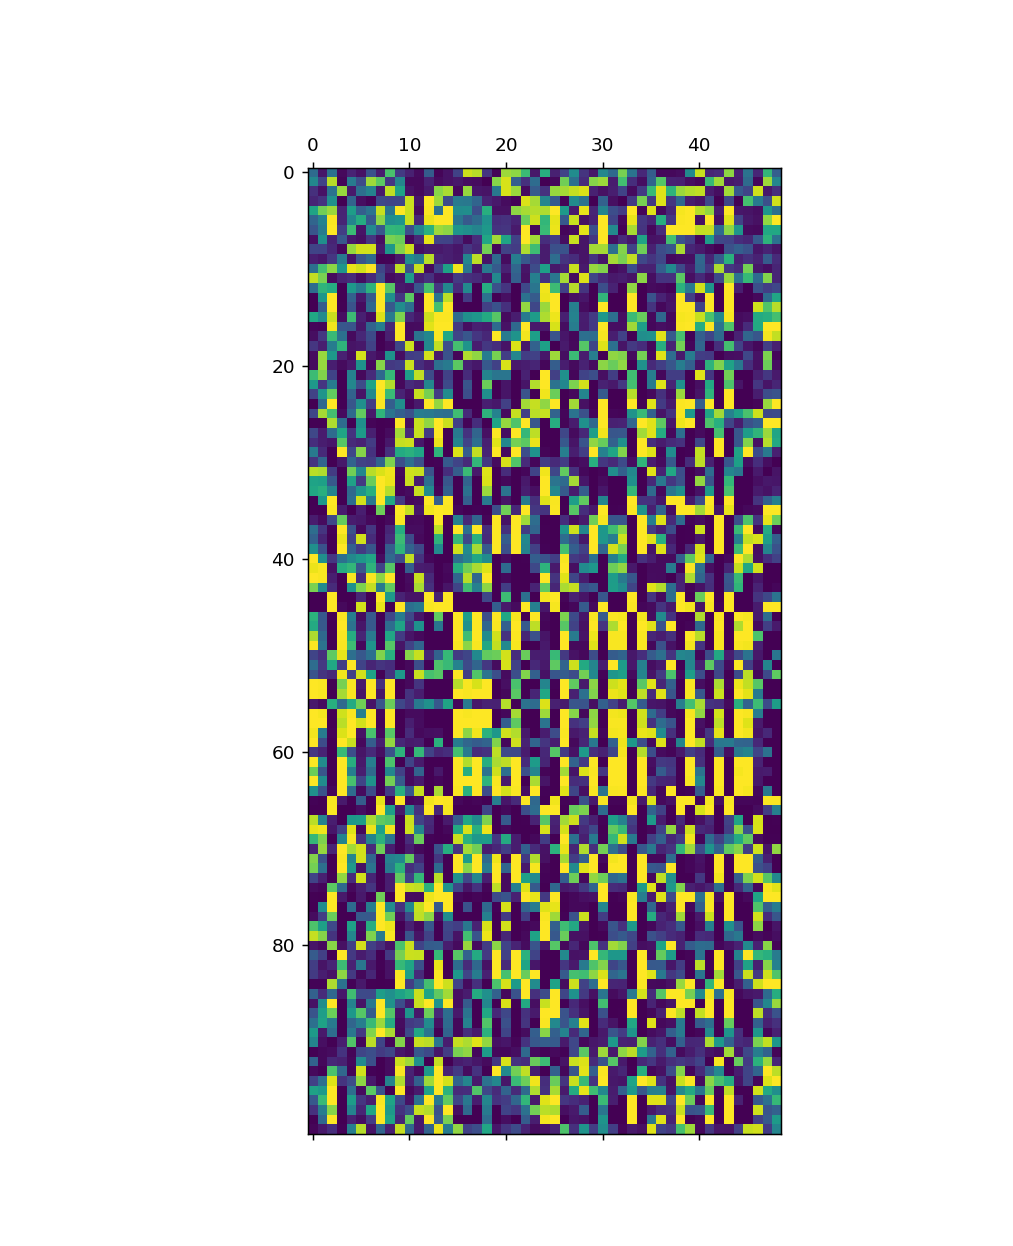

<IPython.core.display.Javascript object>


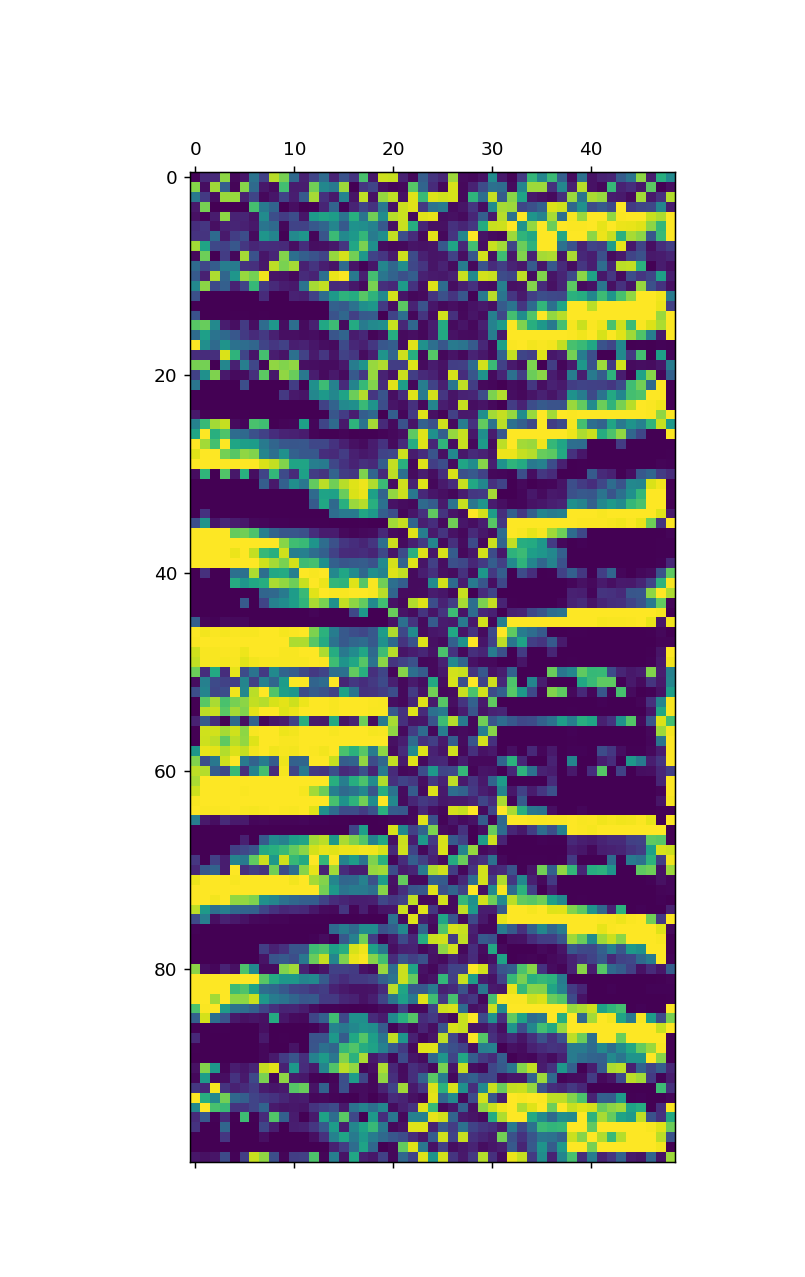

<IPython.core.display.Javascript object>


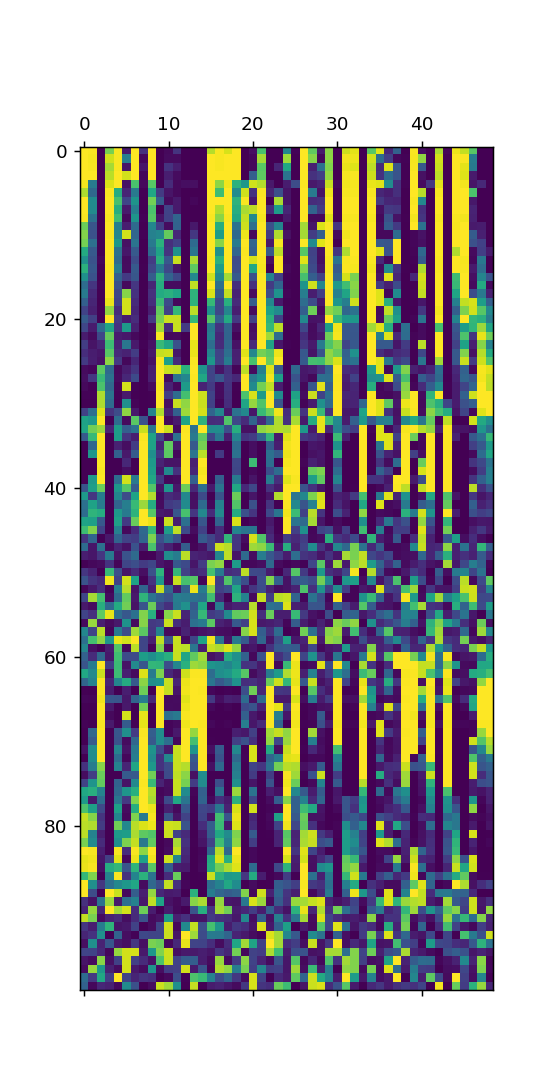

<IPython.core.display.Javascript object>


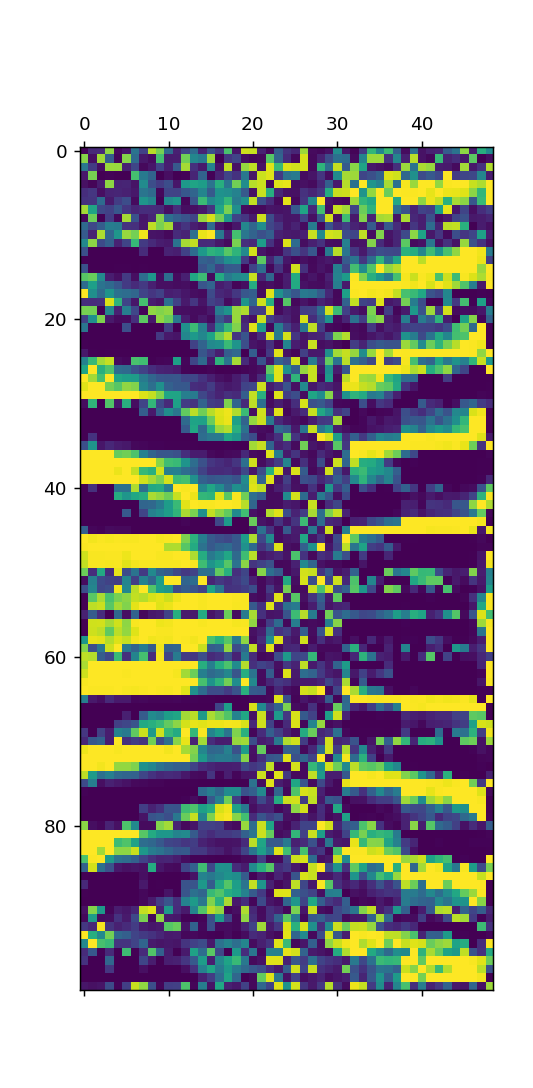

In [12]:
# filename = '/home/schlowmo/Repositories/OCTA/octa/results/26_03_2018/26_03_17_26_rec_weights_last.npy'
date = '01_11_2018'
timestamp = '17_26'
# name = 'rec_c' 
# name = 'rec_p'
# name = 'pred'
# name = 'error'
name = 'inp'
# name += '_weights_last'
filename = '/home/schlowmo/Repositories/OCTA/results/{}/{}_{}_{}.npy'.format(date, date[:5], timestamp, name + '_weights_last')
# weight_matrix = load_weights(filename=filename, dim=dimensions[name])

# permutation = get_permutation(weight_matrix=weight_matrix, axis=1)

# sorted_weights = sort_weight_matrix(weight_matrix=weight_matrix, permutation=permutation)
s = SortMatrix(nrows=100, ncols=49, filename=filename, axis=1)

plt.matshow(s.matrix)
plt.draw()
plt.matshow(s.sorted_matrix)
plt.draw()
# permutation = get_permutation(weight_matrix=weight_matrix, axis=0)

# sorted_weights = sorted_weights[permutation, :]
s = SortMatrix(nrows=100, ncols=49, filename=filename, axis=0)
plt.matshow(s.sorted_matrix)


name = 'inp' 
filename = '/home/schlowmo/Repositories/OCTA/results/{}/{}_{}_{}.npy'.format(date, date[:5], timestamp, name + '_weights_last')
# weight_matrix = load_weights(filename=filename, dim=dimensions[name])
# permutation = get_permutation(weight_matrix=weight_matrix, axis=1)

# sorted_weights = sort_weight_matrix(weight_matrix=weight_matrix, permutation=permutation)
s = SortMatrix(nrows=100, ncols=49, filename=filename, axis=1)
# plt.matshow(weight_matrix)
plt.draw()
plt.matshow(s.sorted_matrix)
plt.savefig('/home/schlowmo/Repositories/OCTA/plots/sorted_input_weights_{}_{}.png'.format(date[:5], timestamp),
         dpi=600, orientation='landscape', 
         bbox_inches='tight', pad_inches=0.5)

# Understanding weight distribution
In order to perform any kind of regularizer such as L1 or L2 (see below for mapping on spiking networks) we need to define a critereon to switch between different regularizers. To understand which local metric can be exploited we start looking at the weight distribution before and after learning
(Remark, I am not sure how weight re-initialization affects the distribution!)

In [ ]:
synapse_group = compressionWTA.Groups['synInpWTA1e']
weights_after_learning = np.zeros((synapse_group.source.N, synapse_group.target.N)) * np.nan
weights_after_learning[synapse_group.i, synapse_group.j] = synapse_group.w_plast

plt.hist(weights_before_learning.flatten(), color='b', alpha=0.4, bins=20)
non_zero_avg_weight_before_learning = np.true_divide(weights_before_learning.flatten().sum(),(weights_before_learning.flatten()!=0).sum(0))

weights_before_learning[weights_before_learning==0] = np.nan
non_zero_weight_avg_before_learning = np.nanmean(weights_before_learning.flatten(()))

# plt.hold(True)
plt.vlines(x=non_zero_avg_weight_before_learning, ymin=0, ymax=3000, color='b', label='Mean: {}'.format(round(non_zero_avg_weight_before_learning, 3)))
plt.hist(weights_after_learning.flatten(), color='r', alpha=0.4, bins=20)
non_zero_avg_weight_after_learning = np.true_divide(weights_after_learning.flatten().sum(),(weights_after_learning.flatten()!=0).sum(0))

weights_after_learning[weights_after_learning==0] = np.nan
non_zero_weight_avg_after_learning = np.nanmean(weights_after_learning.flatten())
plt.vlines(x=non_zero_avg_weight_after_learning, ymin=0, ymax=3000, color='r', label='Mean: {}'.format(round(non_zero_avg_weight_after_learning, 3)))
plt.legend()
plt.show()



# Elementwise correlation of weight matrices

<IPython.core.display.Javascript object>


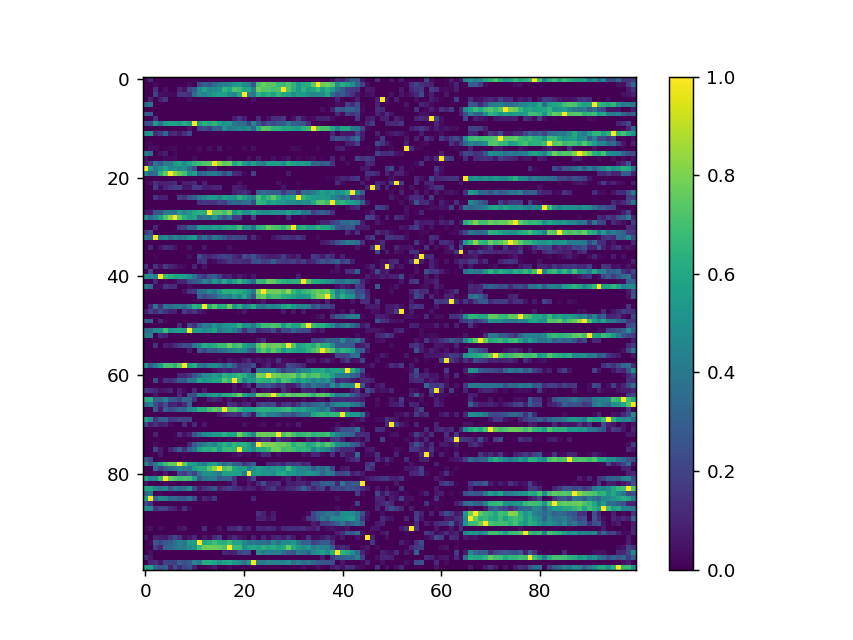

<IPython.core.display.Javascript object>


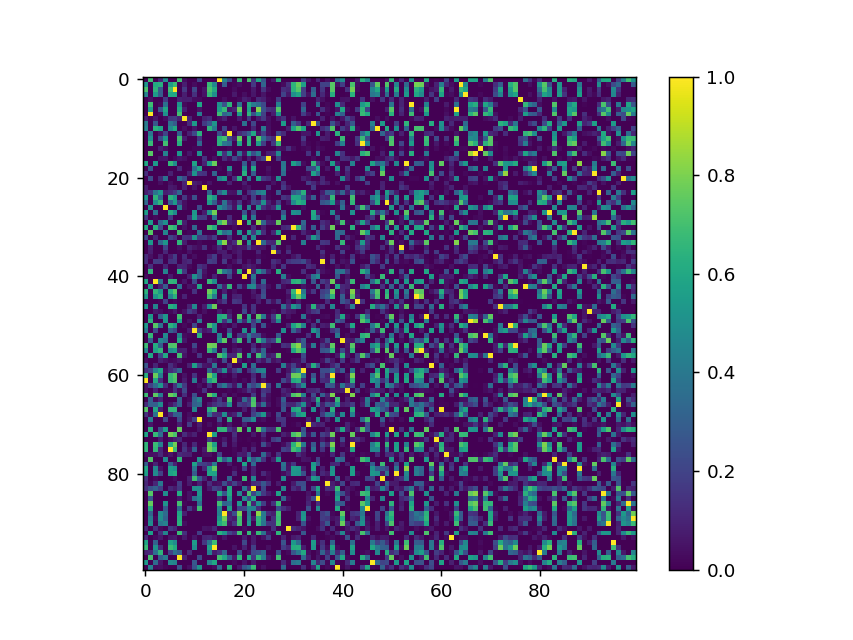

<IPython.core.display.Javascript object>


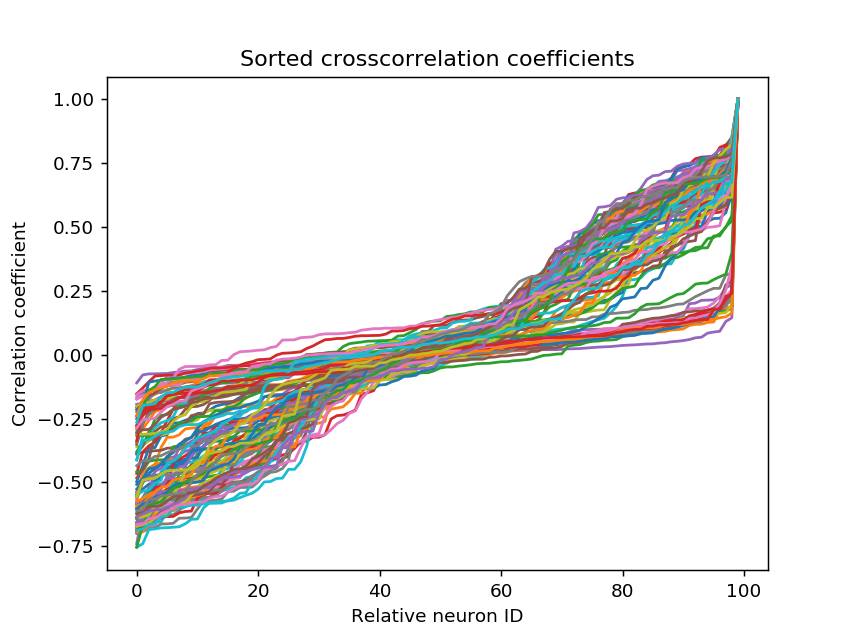

<IPython.core.display.Javascript object>


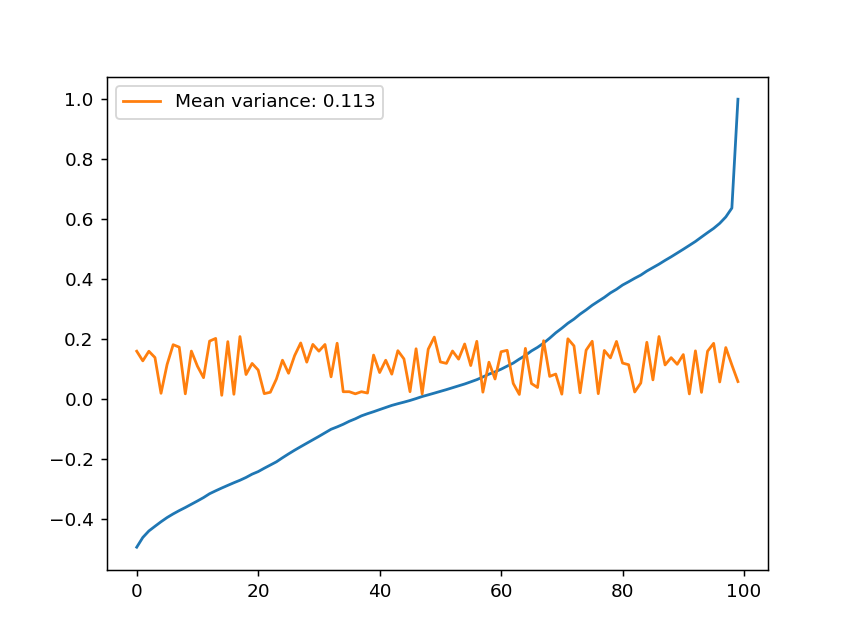

82


<IPython.core.display.Javascript object>


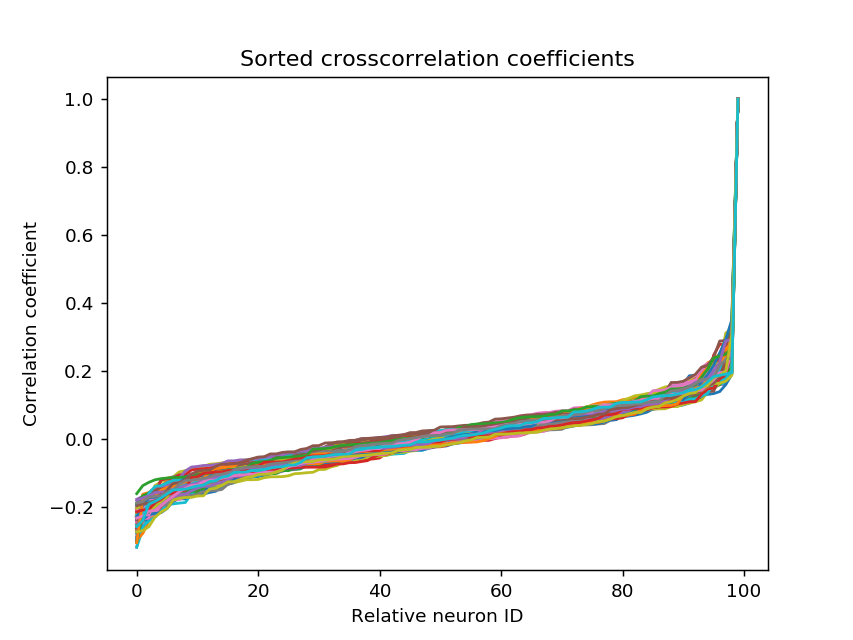

In [6]:
# synapse_group = compressionWTA.Groups['synInpWTA1e']
# synapse_group = compressionWTA.Groups['synWTAWTA1e']
# data = np.reshape(synapse_group.w_plast , (synapse_group.source.N, synapse_group.target.N))
date = '01_11_2018'
timestamp = '17_26'
name = 'rec_c' 

name = 'rec_p'
# name = 'pred'
name = 'error'
# name = 'inp'
nrows=100
ncols=100
filename = '/home/schlowmo/Repositories/OCTA/results/{}/{}_{}_{}.npy'.format(date, 
                                                                             date[:5], 
                                                                             timestamp, 
                                                                             name + '_weights_last')
data = load_weights(filename=filename, nrows=nrows, ncols=ncols)

plt.figure(1)
# data = weights_before_learning
R = np.corrcoef(data.T)
s = SortMatrix(nrows=nrows, ncols=ncols, matrix=R)
# permutation = get_permutation(weight_matrix=R, axis=0)
# sorted_correlation = sort_weight_matrix(weight_matrix=R, permutation=permutation)
plt.imshow(R, vmin=0, vmax=1)
plt.colorbar()
plt.draw()
plt.savefig('/home/schlowmo/Repositories/OCTA/plots/unsorted_rec_weight_correlation.png', dpi=600,
           orientation='landscape',bbox_inches='tight', pad_inches=0.5)
plt.show()
plt.figure(2)
plt.imshow(s.sorted_matrix, vmin=0, vmax=1)

plt.colorbar()
plt.draw()
plt.savefig('/home/schlowmo/Repositories/OCTA/plots/sorted_rec_weight_correlation.png', dpi=600,
           orientation='landscape',bbox_inches='tight', pad_inches=0.5)
plt.show()
plt.figure(3)
R_mean = np.zeros((np.shape(data.T)[0], np.shape(data.T)[0])) * np.nan
for index in range(ncols):
    sorted_indices = np.argsort(R[index])
    R_mean[index, :] = sorted(R[index])
    plt.plot(sorted(R[index]), label='{}'.format(index))

    plt.draw()
plt.title('Sorted crosscorrelation coefficients')  
plt.xlabel('Relative neuron ID')
plt.ylabel('Correlation coefficient')
plt.savefig('/home/schlowmo/Repositories/OCTA/plots/var_rec_weight_correlation.png', dpi=600,
            orientation='landscape',bbox_inches='tight', pad_inches=0.5)
plt.show()
plt.figure(4)
mean_corr = np.nanmean(R_mean, 0)
plt.plot(mean_corr)

# make an array v[49] so v[5] is variance of column 5, etc.
variance = np.var(R_mean, axis=1)
plt.plot(variance, label='Mean variance: {}'.format(round(np.mean(variance), 3)))
plt.legend()
plt.show()
print(len(mean_corr[mean_corr<0.4]))
plt.figure(5)
# data = np.clip(np.random.normal(0.45, 0.25, (nrows,ncols)), 0, 1)
data = np.clip(np.random.gamma(0.5, 1.0, (nrows,ncols)), 0, 1)
R = np.corrcoef(data.T)
R_mean = np.zeros((np.shape(data.T)[0], np.shape(data.T)[0])) * np.nan
for index in range(ncols):
    sorted_indices = np.argsort(R[index])
    R_mean[index, :] = sorted(R[index])
    plt.plot(sorted(R[index]), label='{}'.format(index))

    plt.draw()
plt.title('Sorted crosscorrelation coefficients')  
plt.xlabel('Relative neuron ID')
plt.ylabel('Correlation coefficient')
plt.savefig('/home/schlowmo/Repositories/OCTA/plots/var_random_rec_weight_correlation.png', dpi=600,
            orientation='landscape',bbox_inches='tight', pad_inches=0.5)
plt.show()

# Visualizing example mean variance evolution during training

In [ ]:
# Mean of variance over time
mean_variance_time = [0.030323781498466346, 0.025941791711950882, 0.027270521998262239, 
                      0.027809857074318656, 0.030813735655732845, 0.037048330676974078, 
                      0.049381256736549972, 0.0653578283571392, 0.075060656219666996, 
                      0.091992506550756553, 0.1194703433760832, 0.12718004872072841, 
                      0.14582747845720934, 0.15508356058171874, 0.16489606224881129, 
                      0.1744430844149184, 0.17920143641238584, 0.18502882592239087, 
                      0.20187670852317885, 0.19344555257591017, 0.19229017414334604, 
                      0.18881024556209758, 0.18911146120987954, 0.19041731182416963, 
                      0.18396971700469439, 0.18252875241516414, 0.18776114460732118, 
                      0.20640813463196617, 0.2141659419915258, 0.20659478917675964, 
                      0.22862036278663272, 0.2364146925311193, 0.23312192934033038, 
                      0.22870155523811944, 0.22604105081141967, 0.22128747045724578, 
                      0.21953286345454745, 0.21940528841523249, 0.22253188362200188, 
                      0.22285879634450911, 0.21142069848621334, 0.21002116274381408, 
                      0.21871295020955531, 0.22468623390344508, 0.22537446411935458, 
                      0.2293486919834733, 0.23585809137890748, 0.24730923677841829, 
                      0.25153295107502788, 0.25432340495778721, 0.25833924644902312, 
                      0.26485071670752214, 0.27017126757021648, 0.27429470143581647, 
                      0.27648563651635211, 0.27929700621931819, 0.28500740428560717, 
                      0.29088420672135634, 0.28925392803397965, 0.28233316473018943, 
                      0.25339986156689115, 0.24859055796316271, 0.25052203322265149, 
                      0.25446332697351653, 0.25327067886821408, 0.25692763566730686, 
                      0.25893516326063171, 0.2567722889424004, 0.25704663941925959, 
                      0.25956437713641867, 0.26263784709629145, 0.26723413840254751, 
                      0.2653568023954106, 0.26377847789744213, 0.2689821467809354, 
                      0.26222933108603991, 0.26676306924589505, 0.27402837177249906, 
                      0.26841150151687437, 0.26760365350243348, 0.24267607268958338, 
                      0.2432956148601054, 0.24271754100617693, 0.23731359079834499, 
                      0.24072345871372242, 0.24525585614737655, 0.24116263989230763, 
                      0.23377462602017118, 0.22664033750613682, 0.22065248542673024, 
                      0.21634510085448733, 0.20968739896928421, 0.20867801221801846, 
                      0.20484342797894639, 0.20336079726491171, 0.2046876585693069, 
                      0.20816706496558543, 0.20670211046413831, 0.20684449235663596, 
                      0.20655336975900246]
tmp = [0.029066749825051547, 0.027615396319295035, 0.029044716622005702, 0.034927591034108925, 0.046615691127470132, 0.056616392115635968, 0.069080235387779659, 0.083450567640062395, 0.088458715414659148, 0.09854480079726069, 0.11255419469501535, 0.11830774524545021, 0.1259528998056906, 0.13282200002497654, 0.1373307253965578, 0.14572330484177914, 0.16049250788985861, 0.16704128055047807, 0.18138005801831081, 0.19321218446885458, 0.20069959943568066, 0.20436507762852824, 0.21333189062174374, 0.21991213958777556, 0.22605750829564605, 0.22692862616306567, 0.22678135286533521, 0.24436979608138362, 0.2418753687730664, 0.24756083366333248, 0.25414976348120566, 0.25525568659192482, 0.25713872819135497, 0.25399051257799643, 0.25397540580811806, 0.25568237483641437, 0.25709505634638485, 0.26106211767826837, 0.25463508270755209, 0.248280481536201, 0.24852861306681004, 0.24981100354459779, 0.25246444945048235, 0.25234875437590898, 0.25592086118843338, 0.26655040191444485, 0.2620463011305868, 0.26355737810146157, 0.26605155457766999, 0.2779260944031105, 0.2811392677153759, 0.28652249857323014, 0.29071680357600493, 0.28256663523335651, 0.29227049124253091, 0.28944553266317385, 0.2909408357956032, 0.29455628729779421, 0.28826007368756196, 0.2899800655606421, 0.26242625635161843, 0.26573607714163122, 0.26783792992862737, 0.26176514736095136, 0.26412128976632887, 0.26399700881842192, 0.26183832114617867, 0.26184077384982224, 0.2562035763391311, 0.25922514245388462, 0.25153302318800735, 0.25132594210286718, 0.25060362030379074, 0.24730956793825798, 0.2459410414282347, 0.24236478802974354, 0.24490530520598203, 0.23508047288443679, 0.23405400017836794, 0.23497231410607189, 0.21501907953277491, 0.21060726255847748, 0.21265440335069552, 0.21293630761497442, 0.21334948463281325, 0.21309004360460371, 0.21146139954185375, 0.21463410886675297, 0.21462577208703382, 0.21431881200867006, 0.21609191615896539, 0.21503811044108556, 0.21892543771352177, 0.21669562014186944, 0.21567894471267937, 0.21842979411003857, 0.21745702262609387, 0.21894311544994957, 0.21663090676822905, 0.21656688153725445]
tmp2 = [0.029245230205721232, 0.026623275957478411, 0.026469242794984287, 0.032605098938553741, 0.03894901635002921, 0.051421688785673471, 0.061210789159636014, 0.072405825330306248, 0.089675576357422987, 0.1078384796367769, 0.12181677348085762, 0.12558098756892852, 0.12714703034232644, 0.13680374960018227, 0.1400312404126787, 0.15153665734589444, 0.16605807900944722, 0.17535984060237281, 0.18280366355530708, 0.19385121517211182, 0.20669873646756445, 0.21342935538808502, 0.22129177567269881, 0.23043103490827568, 0.23955996929393139, 0.24018312191720631, 0.24540334481501463, 0.24820038647608647, 0.25305524552960135, 0.24819797596426166, 0.24762492071576411, 0.25552741676797242, 0.25097439719608589, 0.25338141574582779, 0.25596460685804528, 0.25885499416554997, 0.25534527873099705, 0.25588703708153365, 0.26070956454827809, 0.2607379894050923, 0.26437640928579692, 0.26450618995580677, 0.26417356009132192, 0.26689187408986331, 0.27097579582200182, 0.27024327933473702, 0.27023420612267807, 0.27636327600203386, 0.27408211849873093, 0.2762618556637334, 0.27792370421948548, 0.27887935664298658, 0.28142556527477236, 0.28756182047444784, 0.28847537739950152, 0.289270087818225, 0.29814624704078047, 0.29334981517245845, 0.29608381147458918, 0.29275511808387167, 0.27801220447817726, 0.27749850429986866, 0.27678469755028906, 0.28469115274639162, 0.2886087396056381, 0.28797686844856013, 0.29076763089222307, 0.28773912028402449, 0.29090075355323408, 0.29461613374074269, 0.29827395279112418, 0.29412419505660836, 0.29330105668783679, 0.29714106163836368, 0.2934981966425006, 0.2876875661955472, 0.2844767428613863, 0.27797890271402836, 0.26911320625431701, 0.26950697950635455, 0.23210266161401508, 0.22938362777114776, 0.22814572754872123, 0.22714903635208014, 0.22338851438948229, 0.23380940534048758, 0.22848669477995656, 0.22886010372726059, 0.2327922434804009, 0.22403271626270696, 0.23327008136734545, 0.22765837983677292, 0.23378508493643133, 0.2338592274853345, 0.23658015393798026, 0.23139685725283896, 0.23700914772510026, 0.22769208394310109, 0.23397448435111579, 0.22590597070772159]
synapse_group = compressionWTA.Groups['synInpWTA1e']
plt.figure()
ax = plt.subplot(111)
ax.plot(np.asarray(mean_variance_time))
# ax.plot(tmp_statemon.t/ms, tmp_statemon.mean_variance_time[0])
plt.hold(True)
ax.plot(np.asarray(tmp), color='r')
ax.plot(np.asarray(tmp2), color='g')
ax.set_xticklabels(np.arange(0, 11, 2))
ax.set_xlabel('Time [s]')
ax.set_ylabel('Mean of variance of correlation coefficients')


In [ ]:
# lol = [0.029203032044645208, 0.026907794471294939, 0.028692428948730017, 0.033173544180406238, 0.039907936927600009, 0.052212303615101846, 0.068779774106059288, 0.079055844934050726, 0.095293922419085311, 0.10779903044785238, 0.11636472851619788, 0.13217932862473744, 0.14331071418443025, 0.15156756024515333, 0.17193364729772542, 0.18943841449120583, 0.19703692201063464, 0.21142090615068446, 0.22456935780938342, 0.22661341034796778, 0.2316112196491911, 0.23828184587907239, 0.2449423837961702, 0.25570717706441448, 0.26603764857833456, 0.2744194093709687, 0.25732547962778468, 0.27281630856276901, 0.28314190569696507, 0.28794089747860047, 0.28340949052893838, 0.276723246908052, 0.27358780796427662, 0.27373802456254498, 0.27151147342240478, 0.27036944953259889, 0.27070000896700391, 0.26984790827239191, 0.26972206434412188, 0.26546687328640362, 0.26176825849797852, 0.26393416531959885, 0.2624490490378974, 0.25554537181215387, 0.26155703260107893, 0.27514583579130747, 0.28161576728968929, 0.28647542433385914, 0.2854171065270808, 0.27758730510460478, 0.26875768936596056, 0.26564837246005474, 0.26141266824296311, 0.25534442679145458, 0.2505612445252598, 0.24785632260882506, 0.25720181978095458, 0.25913946048031533, 0.25913300866120625, 0.26055233182601573, 0.16788604288342901, 0.17040685611003711, 0.16909238194387799, 0.16909227963982335, 0.17204952577604779, 0.17588011579072704, 0.17604552039634527, 0.176572934854484, 0.18323938326282146, 0.19460278238034193, 0.20436383151653917, 0.20124318863159324, 0.20265851791041831, 0.21171955632763945, 0.2062176565470423, 0.20975311749305237, 0.21160479388870204, 0.21045852359280609, 0.21806754742395557, 0.21558416209807468, 0.20502666368749667, 0.20996838125156209, 0.20510560879177098, 0.21005824373563689, 0.21147902649900793, 0.21033123965207243, 0.20719271021825519, 0.20681705561096228, 0.20894702773927878, 0.21071646379188305, 0.21444814122387207, 0.21657513602454384, 0.21917433166371336, 0.22337461360624714, 0.22403324660144458, 0.22709370485718289, 0.23335604224140008, 0.23822615485242049, 0.24098874138418355, 0.24149802898063785, 0.22832254310416814, 0.2308097818039315, 0.23172230856155543, 0.23288482318595274, 0.2328336539395425, 0.23149917116657598, 0.22888035244952565, 0.22771926474358883, 0.2268785030856787, 0.22188837635433775, 0.22522791168520256, 0.21603193472791724, 0.22213456915182819, 0.22051201433409348, 0.21622103879901369, 0.21267257170704387, 0.20984301425983973, 0.20849982618531537, 0.21607859863931927, 0.2101107022291045, 0.16137424099070488, 0.16771042461045721, 0.1687968683303922, 0.16379086359004674, 0.17117846055695402, 0.17546924182784415, 0.17597032340578816, 0.17556257942238843, 0.18151308104634223, 0.17899175035766129, 0.18563345568780959, 0.17996831969451366, 0.1804185540268303, 0.18022393491354635, 0.18532468713921069, 0.18308903625865069, 0.18183981605093993, 0.18296938581330052, 0.18586732246352194, 0.181010043605183, 0.16750413827790511, 0.16629212050725417, 0.16856084965479284, 0.16564288507898026, 0.17037196686554734, 0.16982532126094751, 0.16990171672382018, 0.16700601477498686, 0.16342370457918079, 0.16266981659092461, 0.16813203356254447, 0.16615814649146673, 0.16764002075943338, 0.16965489504587414, 0.17220910067570266, 0.17074873900242704, 0.17103447659638524, 0.17473495584820936, 0.17750712445578704, 0.17689041557206234, 0.14783796842223826, 0.14847274873583916, 0.15156975577890927, 0.15246369265410795, 0.15188926638945791, 0.15453391631885249, 0.15587281859134702, 0.15915624595673719, 0.1617982136189027, 0.16434316797792042, 0.16498908683702057, 0.16838715875814037, 0.17151770647335529, 0.17301152776991913, 0.17463923461932973, 0.17904543169767526, 0.184771750952613, 0.18569879243096801, 0.18994242122144814, 0.19612287733013861, 0.14227482789139148, 0.14346800838739684, 0.15292371872565799, 0.15399152947487715, 0.15821571161673204, 0.16552319793620596, 0.16573530775541359, 0.17263774011710567, 0.16908049488920479, 0.17549262565316007, 0.17573908179627371, 0.18373948652978067, 0.18499789447232529, 0.18754090529081408, 0.19693039317123121, 0.19171850020437509, 0.196101569462241, 0.19879419509318455, 0.19976470595389506, 0.19923281934987686]
# data = compressionWTA.Groups['synInpWTA1e'].mean_variance_time
# data = tmp2
cInd = np.arange(500,len(tmp_statemon_c.mean_variance_time[0]), 500 )
data = tmp_statemon_c.mean_variance_time[0][cInd]
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
plt.figure()
plt.semilogy(data)
plt.show()
plt.figure()
x = np.diff(np.log(data))
# x[x==0] = np.nan
moving_avg = moving_average(x, n=5)
plt.scatter(np.arange(0, len(data)-1), np.diff(np.log(data)))
plt.plot(moving_avg, color='r')
plt.grid(True)
plt.savefig('/home/schlowmo/Repositories/OCTA/plots/L1_L2_switching_criteron.pdf', dpi=600,
           orientation='landscape',bbox_inches='tight', pad_inches=0.5)
plt.show()
plt.figure()
moving_avg = moving_average(np.diff(data), n=5)
plt.scatter(np.arange(0, len(data)-1), np.diff(data))
plt.plot(moving_avg, color='r')
plt.grid(True)
plt.figure()
plt.plot(data)

In [ ]:
print(tmp_statemon.mean_variance_time)

# Devoloping code snippets

In [ ]:
# weights = np.random.normal(0.4,0.2,4900)
# weights = np.reshape(weights, (100,49))
# print(len(np.linalg.norm(weights, ord=1, axis=1)))
import numpy as np
import matplotlib.pyplot as plt
# weights = np.random.normal(0.4,0.2, 100)
weights = np.random.gamma(0.9, 0.4, 100)
weights = np.clip(weights, 0, 1)
weights[weights<0.1] = 0
print(len(weights[weights==0.0]))
plt.figure()
plt.hist(weights, color='b', alpha=0.2)

# cInd = np.logical_and(weights>0.3, weights<0.7)
print(np.linalg.norm(weights, ord=1))

tmp_weights = weights # - np.mean(weights)
sparsity = 0.3
print(np.sum(tmp_weights))
L1 = np.linalg.norm(tmp_weightsghts, ord=1)
print(L1)
# normalized_weights = (tmp_weights / L1)  + np.mean(weights[weights > 0.2])
normalized_weights = (weights) / (L1/( sparsity * len(weights)))

plt.hist(normalized_weights, color='r', alpha=0.2)
# plt.hist(normalized_weights + weights[weights <= 0.2], color='k', alpha=0.2)
# L1 = np.linalg.norm(weights[weights>0.2], ord=1)
# normalized_weights_2 = (normalized_weights / L1) + np.mean(normalized_weights)
# plt.hist(normalized_weights_2, color='k', alpha=0.2)
# plt.draw()

# plt.show()
# print(np.mean(weights),np.mean(normalized_weights))
# # print(np.mean(weights[weights!=0]), np.mean(normalized_weights[normalized_weights!=0]))
# plt.figure()
# plt.matshow(normalized_weights.reshape(10,10), vmin=0, vmax=1)
# plt.figure()
# plt.matshow(weights.reshape(10,10), vmin=0, vmax=1)

[40.12397533 29.71787042 39.38031411 38.18771448 35.65461452 35.36772851
 37.81887851 34.44716997 41.84198289 34.77771046 33.77462906 34.48716251
 38.62394843 42.28109907 20.30383094 37.80728073 32.36424096 34.14827399
 38.94161128 25.56807925 20.35349244 21.33545024 37.66318519 20.07155308
 34.58306605 30.54098892 37.22448631 28.13066447 38.74263826 39.91904661
 39.50683855 31.77403327 33.59692854 36.58318996 20.33903242 25.22066514
 30.84454939 31.96252104 35.70620666 38.31672034 32.01450608 33.4119713
 26.93250498 37.7663863  38.87605445 38.94148539 33.16114614 39.02833596
 36.85264107]


<IPython.core.display.Javascript object>


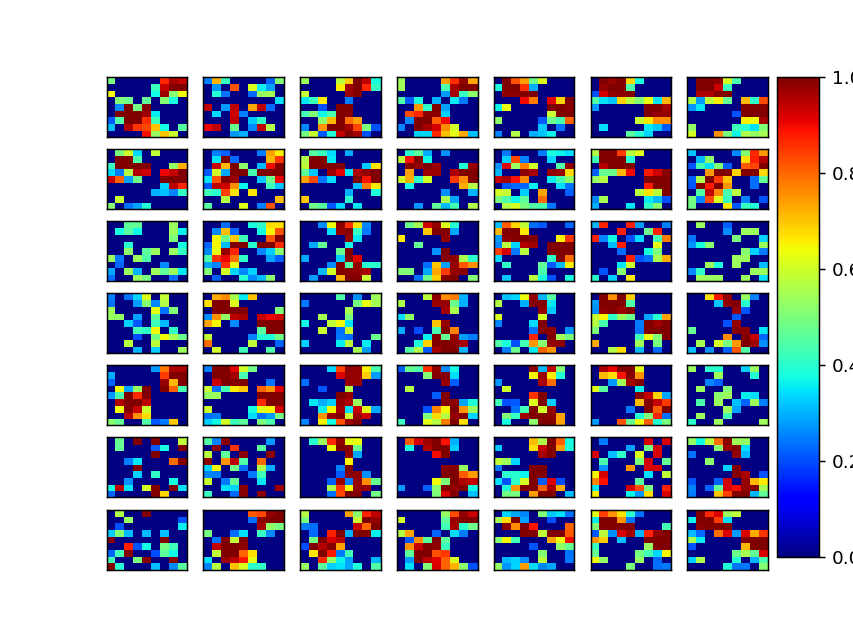

<IPython.core.display.Javascript object>


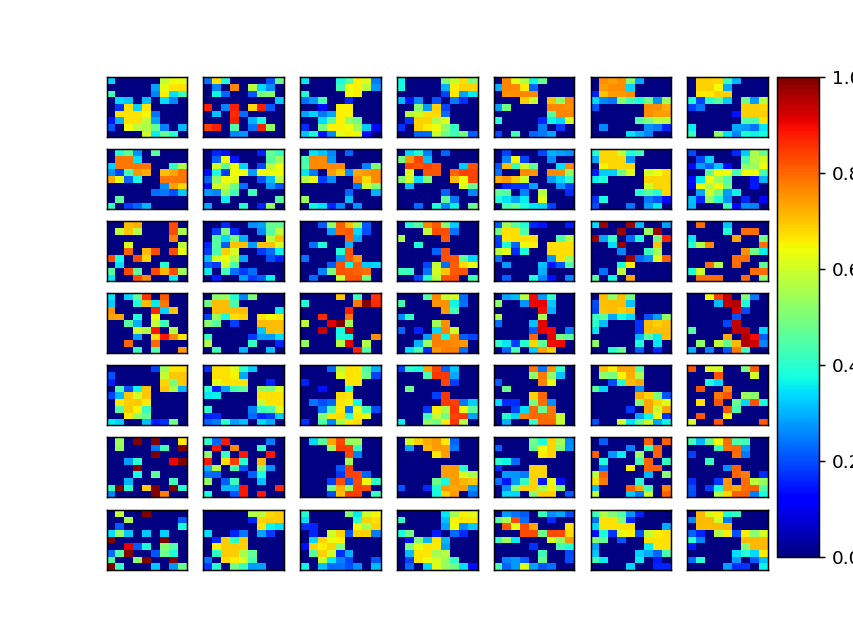

In [58]:
weights = np.reshape(compressionWTA.Groups['synInpWTA1e'].w_plast, (100,49))
sparsity = 0.25
target = sparsity * np.shape(weights)[0]
print(np.sum(weights, axis=0))
weights[weights<0.2] = 0
normalized_weights = weights / np.sum(weights, axis=0) * target
plot_receptive_fields(weights)
plot_receptive_fields(normalized_weights)

## Sorted receptive fields

In [ ]:
synapse_group = compressionWTA.Groups['synInpWTA1e']
# synapse_group = error_connection

# plot_receptive_fields(synapse_group)
load_from_recording = True
sort_receptive_fields = True
data_dir = '/home/schlowmo/Repositories/OCTA/results/'
date = '19_09_2018'
timestamp = '18_56'
name = 'inp'
filename_weights = data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, 
                                                                    date[:5], 
                                                                    timestamp,
                                                                    name)
weight_matrix = load_weights(filename=filename_weights, nrows=100)
if load_from_recording:
    synapse_group.w_plast = weight_matrix.flatten()
name = '{}_{}_sorted'.format(synapse_group.source.name, synapse_group.target.name)
neu_ind = [5]

if sort_receptive_fields:
    sort_according_to = 'rec_c'
    filename_weights = data_dir + '{}/{}_{}_{}_weights_last.npy'.format(date, 
                                                                        date[:5], 
                                                                        timestamp,
                                                                        sort_according_to)
    s = SortMatrix(nrows=49, ncols=49, filename=filename_weights, axis=1)

for index in neu_ind:
    plot_receptive_fields_sorted(synapse_group, index=index, permutation=s.permutation)
    plt.draw()
    plot_name = name + '_{}'.format(index)
    if load_from_recording:
        plt.savefig('/home/schlowmo/Repositories/OCTA/plots/receptive_fields_{}_{}.pdf'.format(plot_name, 
                                                                                               date[:5] + '_' + timestamp), 
                    dpi=600, orientation='landscape', 
                    bbox_inches='tight', pad_inches=0.5)
   

## Weight quantization

In [ ]:
def quantize_weights(weights, threshold_low=0.97, threshold_high=0.97):
    quantized_weights = np.zeros(np.shape(weights)) * np.nan
    pruned_indices = weights <= threshold_low
    low_indices = np.logical_and(weights > threshold_low, weights < threshold_high)
    high_indices = weights >= threshold_high
    quantized_weights[pruned_indices] = 0
    quantized_weights[low_indices] = 0.5
    quantized_weights[high_indices] = 1.0
    return quantized_weights


In [ ]:
data_dir = '/home/schlowmo/Repositories/OCTA/results/'
weights = np.load(data_dir + '24_08_2018/24_08_14_28_inp_weights_last.npy')
weights = np.reshape(weights, (100,49))
quantized_weights = quantize_weights(weights)
plot_receptive_fields(weights)
plot_receptive_fields(quantized_weights)
plt.show()
print(np.sum(weights!=0))
print(np.sum(quantized_weights!=0))

In [ ]:
print(quantized_weights[quantized_weights==0.5])
print(np.sum(quantized_weights!=0, axis=0))

In [ ]:
variance_test = np.asarray(state_mon_i_mem_var.Imem_var / pA)
print(np.shape(variance_test))
print(np.max(variance_test[2,:]/(10**-9)))
normalized_variance = variance_test / np.max(variance_test)
# normalized_variance = (variance_test - np.min(variance_test)) / (np.max(variance_test)- np.min(variance_test))
# print(np.max())
threshold = 0.6
# plt.plot(variance_test[5, :]/(10**-12))
plt.plot(normalized_variance[35,:])
plt.draw()
plt.show()
plt.plot(normalized_variance[35,:] - threshold)
plt.draw()

In [ ]:
# synapse_group = compressionWTA.Groups['synWTAWTA1e']
synapse_group = compressionWTA.Groups['synInpWTA1e']
# Set layout
app = QtGui.QApplication.instance()
if app is None:
    app = QtGui.QApplication(sys.argv)
else:
    print('QApplication instance already exists: %s' % str(app))
pg.setConfigOption('background', 'k')
pg.setConfigOption('foreground', 'w')
# pw = pg.plot()
win = pg.GraphicsWindow(title='Adjacency plot')
win.resize(1024, 768)
# The code above is defined outside the function
adjacency_plot = win.addPlot(title='Adjacency plot: \n{}\n{}'.format(synapse_group.source.name,
                                                                  synapse_group.target.name))


num_source_neurons = synapse_group.source.N
num_target_neurons = synapse_group.target.N

# x = np.arange(0, num_target_neurons, 1)
# y = np.arange(0, num_source_neurons, 1)
# X, Y = np.meshgrid(x, y)
data = np.zeros((2, num_source_neurons, num_target_neurons))
data[:, synapse_group.i, synapse_group.j] = synapse_group.w_plast
print(np.shape(data))
# pos = np.array([0.0, 1.0])
# color = np.array([[0,0,0,255], [255,0,0,255]], dtype=np.ubyte)
# ncolors = 512

# lut = np.zeros((256,3), dtype=np.ubyte)
# lut[:128,0] = np.arange(0,255,2)
# lut[128:,0] = 255
# lut[:,1] = np.arange(256)

pos = np.array([0.0, 0.5, 1.0])
# color needs as many colors as postions are specified
color = np.array([[0,0,0,255], [255,177,124,255], [255,102,0,255]], dtype=np.ubyte)
cm = pg.ColorMap(pos, color)
stops, colors = cm.getStops('float')
print(colors)
lut = cm.getLookupTable(0.0, 1.0, 256)


adjacency_matrix = pg.ImageView()
adjacency_matrix.setImage(data)
adjacency_matrix.setColorMap(cm)

adjacency_matrix.show()


app.exec()

In [ ]:
app.exec()

In [ ]:
date = '09_05_2018'
timestamp = '18_38'
name = 'inp'
filename = '/home/schlowmo/Repositories/OCTA/results/{}/{}_{}_{}.npy'.format(date, 
                                                                             date[:5], 
                                                                             timestamp, 
                                                                             name + '_weights_last')
weight_matrix = load_weights(filename=filename, dim=dimensions[name])
plot_adjacency_matrix(synapse_group=None, weight_matrix=weight_matrix)

# Old code snippets, just for storing


## Visualize input spikes in image coordinates

In [ ]:
events = ind2events(np.asarray(compressionWTA.Monitors['spikemonWTAInp'].i),
                    np.asarray(compressionWTA.Monitors['spikemonWTAInp'].t / ms),
                    True,
                    np.sqrt(compressionWTA.Monitors['spikemonWTAInp'].source.N).astype(int))
visualizer = Visualize()
visualizer.plot(events, time_window=5)

## Testbench visualization

In [19]:
import numpy as np
from brian2 import us, ms
from pyqtgraph.Qt import QtCore, QtGui
import pyqtgraph as pg

from teili.stimuli.testbench import OCTA_Testbench
from teili.tools.plotter2d import Plotter2d

class monitor:
    def __init__(self, i, t):
        self.i = i
        self.t = t
name = 'spikemon_compressionWTA'
filename = data_dir + '{}/{}_{}_{}.npy'.format(date, 
                                               date[:5], 
                                               timestamp,
                                               name)
data = np.load(filename).astype(int)
print(len(data[0,:]))

spike_mon_compression = monitor(data[0, :40000], data[1,:40000])
print(len(spike_mon_compression.i))

app = QtGui.QApplication.instance()
if app is None:
    app = QtGui.QApplication(sys.argv)
else:
    print('QApplication instance already exists: %s' % str(app))


testbench = OCTA_Testbench()


# testbench.translating_bar_infinity(length=10, nrows=64, orientation='vertical', shift=32,
#                                  ts_offset=10, artifical_stimulus=True, rec_path=None,
#                                  returnEvents=False)
# testbench.rotating_bar(length=10, nrows=10, direction='cw', ts_offset=3,
#                        angle_step=10, noise_probability=0.2, repetitions=90, debug=False)
# testbench.rotating_bar_infinity(length=10, nrows=64, orthogonal=False, shift=32,
#                               ts_offset=10, artifical_stimulus=True, rec_path=None,
#                               returnEvents=False)
# print(testbench.times)


events = ind2events(np.asarray(spike_mon_compression.i),
                    np.asarray(spike_mon_compression.t),
                    True,
                    10)
# event_monitor = Plotter2d.loaddvs(testbench.events)
event_monitor = Plotter2d.loaddvs(events)
imv1 = event_monitor.plot3d_on_off(plot_dt=3*ms, filtersize=10*ms)

win = pg.GraphicsWindow(title="DVS Spikes")
gridlayout = QtGui.QGridLayout(win)
gridlayout.addWidget(imv1, 1, 1)
win.resize(1500, 1000)
win.setLayout(gridlayout)
win.show()
win.setWindowTitle('DVS plot')
imv1.play(10)

app.exec_()


116319
40000
QApplication instance already exists: <PyQt5.QtWidgets.QApplication object at 0x7f3e3937b798>


0

## Sorting matrices based on similarity
To understand the structure of in the rasterplots but also in the learned weight matrices, we need to sort the weight matrices according to some similarity measure, such as euclidean distance.  
However, the sorting algorithm is completely agnostic to the similarity measure. It connects each node with maximum two edges and constructs a directed graph.   
This sorting is idea is similar to the travel salesman problem.

In [7]:
toSave = np.zeros((2, len(testbench.times)))
toSave[0, :] = testbench.indices
toSave[1, :] = testbench.times
np.save('/home/schlowmo/Repositories/cortexcontrol/input.npy', toSave)

In [ ]:
'''The dimensions are fixed right now in this notebook to make plotting live easier. 
This dictionary will be part of the init function once we implement all functions in a class
'''
dimensions = {'rec_p': (100, 100),
              'rec_c': (49, 49),
              'inp': (100, 49),
              'error': (100, 100),
              'pred': (49, 100)
              }

def compute_distance(x, y):
    '''This function returns the euclidian distance
    of any to vectors x and y
    '''
    return np.linalg.norm(x - y)

def get_similarity_matrix(weight_matrix=None, filename=None, axis=0):
    ''' This function computes a similarity matrix of a given 
    (weight) matrix.
    '''
    # Load weight_matrix if it not given
    if weight_matrix is None:
        weight_matrix = load_weights(filename)
    similarity_matrix = np.zeros((np.size(weight_matrix, axis), np.size(weight_matrix, axis))) * np.nan
    # Loop through both dimensions of the specified matrix
    # and compute the distance between every pairs of vectors

    for index_i in range(np.size(weight_matrix, axis)):
        if axis == 0:
            reference_vector = weight_matrix[index_i, :]
        else:
            reference_vector = weight_matrix[:, index_i]
        for index_j in range(np.size(weight_matrix, axis)):
            if index_i != index_j:
                if axis == 0:
                    comparison_vector = weight_matrix[index_j, :]
                else:
                    comparison_vector = weight_matrix[:, index_j]
                similarity_matrix[index_i, index_j] = compute_distance(reference_vector, comparison_vector)
            else:
                similarity_matrix[index_i, index_j] = np.inf
    return similarity_matrix

def get_permutation(similarity_matrix=None, weight_matrix=None, filename=None, axis=0):
    ''' To sort a given matrix according to its similarity we need to construct
    permutation indices, which are used to sort the matrix. First we find the most
    similar enry in the simialrity matrix. This function allows each node in the similarity
    graph to be only used twice, i.e. each node has maximally two edges connected to it.
    The vector 'degree' keeps track of this. To prevent a loop closure in the similarity graph 
    a proxy vector called 'partner' is used to set the distance between the two ends of the
    similarity graph to infinity.
    '''
    if similarity_matrix is None:
        similarity_matrix = get_similarity_matrix(weight_matrix, filename=None, axis=axis)
    steps = []
    degree = np.zeros((np.size(similarity_matrix, 0)))
    partner = np.arange(np.size(similarity_matrix, 0)) # diagonal was already set to infinity
    while(len(steps)<= np.size(similarity_matrix, 0)-1):
        # Get the index (tuple) of the most similar entry in the similarity matrix
        ind_nearest = np.unravel_index(np.argmin(similarity_matrix, axis=None), similarity_matrix.shape)
        # Define the two to be connected nodes
        vertexA = ind_nearest[0] # we gonna draw an edge between A and B
        vertexB = ind_nearest[1]
        # Increase the (connectivity) degree of these nodes by one
        degree[vertexA] += 1
        degree[vertexB] += 1
        # Draw an edge between the nodes
        steps.append(ind_nearest) # the bag of edges

        # don't use anything more than twice
        ind2exclude = np.where(degree>=2)
        similarity_matrix[ind2exclude, :] = np.inf
        similarity_matrix[:, ind2exclude] = np.inf

        # To prevent loop closure identify the two ends of the graph
        endA = partner[vertexA]
        endB = partner[vertexB]
        # Re-asign the partners of the ends
        partner[endA] = endB
        partner[endB] = endA
        # Set the distance between the new ends of the graph to infinity
        similarity_matrix[endA,endB] = np.inf
        similarity_matrix[endB,endA] = np.inf
        # Break condition that stops the construction of the graph as soon as every node
        # except the two end points are connected twice
        if np.sum(degree) >= np.size(similarity_matrix, 0) * 2 - 2:
            break
    
    # Now that the graph is defined in steps, we can construct the permutation indices
    permutation = []
    # Pick one end of the graph and define as start node
    start_ind = np.where(degree==1)
    start_node = start_ind[0][0]
    permutation.append(start_node)


    while(len(steps)>0):
        # Find the corresponding node which is the end node for the current edge
        corresponding_tuple = [item for item in steps if start_node in item]

        if corresponding_tuple[0][0] == start_node:
            end_node = corresponding_tuple[0][1]
        else:
            end_node = corresponding_tuple[0][0]    
        # Remove nodes from steps  
        steps = [index_i for index_i in steps if index_i!=corresponding_tuple[0]]
        # Add end node of the edge to the list of permutation
        permutation.append(end_node)
        # Set the end_node of the edge to be the start_node of the next edge
        start_node = end_node
    return permutation

def sort_weight_matrix(weight_matrix=None, permutation=[]):
    '''This function returns the sorted (weight) matrix given 
    the permutation indices. 
    '''
    if weight_matrix is None:
        weight_matrix = load_weights()
    if len(permutation) == 0:
        permutation = get_permutation(weight_matrix=weight_matrix)
    sorted_weights = weight_matrix
    if len(permutation) == np.size(sorted_weights, 0) and len(permutation) == np.size(sorted_weights, 1):
        # First sort each row
        for row in range(len(permutation)):
            sorted_weights[row] = sorted_weights[row][permutation]
        # Second sort each column
        sorted_weights = sorted_weights[permutation]
        return sorted_weights
    
    if len(permutation) == np.size(sorted_weights, 0):
        sorted_weights = sorted_weights[permutation, :]

    if len(permutation) == np.size(sorted_weights, 1):
        sorted_weights = sorted_weights[:, permutation]

    return sorted_weights

def sort_spikemon(monitor=None, permutation=None):
    '''Given a monitor and a vector containing permutations (which is given by get_permutations())
    this function will sort the SpikeMonitor to discover strucuture across learning
    '''
    if monitor is None:
        raise UserWarning('Please provide a spikemonitor')
    if permutation is None:
        raise UserWarning('Please provide a list of permuted indices')
    monitor.i = np.asarray([np.where(np.asarray(permutation) == int(i))[0][0] for i in monitor.i])
    return monitor

## Re-initializing of synapses

In [ ]:
synapse_group = compressionWTA.Groups['synInpWTA1e']
num_source_neurons = synapse_group.source.N
num_target_neurons = synapse_group.target.N
data = np.zeros((num_source_neurons, num_target_neurons)) * np.nan
data[synapse_group.i, synapse_group.j] = synapse_group.w_plast

plt.hist(np.sum(data, 0), bins=50)
plt.title('Before re-init')
plt.xlabel('Sum of weights')
plt.ylabel('#')
plt.xlim(0, np.shape(data)[0])
plt.show()
plot_receptive_fields(synapse_group)
plt.show()
# Summing weights
summed_weights = np.sum(data, 0)
tmp_weights = data
reinit_threshold = 0.2
reinit_index = summed_weights<(reinit_threshold*np.shape(data)[0])

# Re-initializing weights with normal distribution
w_mean = 0.45
w_std = 0.25
tmp_weights[:, reinit_index] = np.reshape(np.random.normal(w_mean, w_std, num_source_neurons * np.sum(reinit_index)),
                                          (num_source_neurons, np.sum(reinit_index)))

plt.hist(np.sum(tmp_weights,0), bins=50)
plt.title('After re-init')
plt.xlabel('Sum of weights')
plt.ylabel('#')
plt.xlim(0, np.shape(data)[0])
plt.show()
synapse_group.w_plast = tmp_weights.flatten()
plot_receptive_fields(synapse_group)
plt.show()

## Testing inhibitory plasticity rule

In [ ]:
neuron_obj = DPI()
synapse_obj = DPISyn()
neuron_obj.keywords['model'] += '\n'
neuron_obj.keywords['model'] += '''dImem_var / dt = -(Imem_var + membrane_slope) / tau_var : amp
                       membrane_slope: amp
                       tau_var : second (constant, shared)'''

neuron_obj.parameters['tau_var'] = 50 * ms

synapse_obj = DPISyn()
# synapse_obj.on_pre += '\n'
synapse_obj.keywords['on_pre'] += '''w_plast += inh_learning_rate * (Imem_var_post - variance_th)
        w_plast = clip(w_plast, 0, 1.0)'''

synapse_obj.keywords['model'] += '''inh_learning_rate: 1 (constant, shared)
        variance_th: amp (constant, shared)
                        '''


synapse_obj.parameters['inh_learning_rate'] = 0.001
synapse_obj.parameters['variance_th'] = 5 * nA
synapse_obj.printAll()
print(synapse_obj.on_pre)
print(synapse_obj.model)
print(synapse_obj.parameters)
print(neuron_obj.keywords['model'])
print(neuron_obj.parameters)

In [ ]:
# print(compressionWTA.Groups['synInhWTA1i'].equation_builder.keywords['on_pre'])
# tmp='''w_plast += inh_learning_rate *(Imem_post)
# Ie_syn += Iw_e*w_plast*Ie_gain*(weight>0)/(Itau_e*((Ie_gain/Ie_syn)+1))
# Ii_syn += Iw_i*w_plast*Ii_gain*(weight<0)/(Itau_i*((Ii_gain/Ii_syn)+1))
# '''
# init eq builder
# get object
# add new line to neuron model and on_pre in the syapse
# need Imem_var, tau_mem_var, absolute_slope, Imem_buffer
# add noise and learning_rate to synapse
# add ring buffer for membrane current varince estimation
# compute slope of the ring buffer and square it

# Added neuron equations:
dImem_var / dt = (-Imem_var + membrane_variance_slope) / tau_var : amp
membrane_variance_slope: amp
tau_var : second (constant, shared)
normalized_Imem_var : 1
    
# Added synapse equations
synapse_obj = DPISyn()
synapse_obj.keywords['on_pre'] += '''
        delta_w = inh_learning_rate * (normalized_Imem_var_post - variance_th)
        w_plast = clip(w_plast + delta_w, 0, 1.0)'''

synapse_obj.keywords['model'] += '''inh_learning_rate: 1 (constant, shared)
        variance_th: 1 (constant, shared)
        delta_w : 1
        '''



## Additional run_regularly functions
To test different learning strategies and calculate proxy parameters we developed differen run_regularly functions to track the weights and update them. The functions are all currently in numpy, but potentially can be converted into cpp.  
These functions include:   
*  **re-initializing of weights**, if the summed weight per post-synatpic neuron is below a user defined threshold.
*  **weight regularization** using the average non-zero weight ...
  *  L1 norm: The idea of L1 norm is favour a few weights, which has the consquence of most weights being zero and a few weights are large, e.g. 1.
  *  L2 norm: The ideao of L2 norm is to have many small weights. In standard neural networks synapses can be both, excitatory and inhibitory, which means that weights tend to be centered around 0 if L2 regularization is used. In the spiking neural network case synapses are either inhibitory or excitatory, which has the consequence that the weights tend to be centered around the mean, which is non-zero, e.g. 0.3
*  *Correlation tracking* is used to determine if L1 or L2 weight regularization should be used. The idea is to estimate the slope of the cross-correlation coefficient for each post-synaptic neuron in a  small time window, which is set by the buffer. If the slope tends to become zero the weight regularization switches from L2 (exploration) to L1 (f*acilitation)
*  **Membrane variance** is used to determine if the the inhibitory weight should be increased or decreased. The intuition behind this is that the, since neurons are recurrently connected each post-syaptic membrane variance signals a high correlated activity. In order to diversify the firing pattern inh. synapses connected to neurons with a high membrane variance is increased, lower their variance. On the contrary, if the membrane variance is to low, the inhibitory weights should be decreased to allow those neurons to pick up uncovered inut statstics.
*  **normaization of the membrane variance** is used to make the comparison between neurons easier and set a threshold independent of the unit and between 0 and 1

### Weight reularization
Since weights tend to form useful recotive fields, we would like to have additional regularizers operating on the synaptic weights on a shorter time-scale than weight re-initialization. To do so we introduce two reularization terms (i) L1 and (ii) L2.  
The L2 regularizer tries to push weights towards the mean of the weight distribution whereas L1 will push the weights away from the mean towards the extreme values, e.g. 0 and 1.  
L2 can be described by:  
$$
avg = sum_j(w_{ij} / #syn_j
L2_j = avg/w_j
1 + (||1-L2_j|| * nu) * w_j :(if L2_j>1)
(||L2_j|| * nu) * w_j       :(if L2_j<1)$$

where nu is learning rate, i.e. nu<<1

L1 can be described by:  
$$
avg = sum_j(w_{ij} / #syn_j
L1_j = w_j/avg
1 + (||1-L1_j|| * nu) * w_j :(if L1_j>1)
(||L1_j|| * nu) * w_j       :(if L1_j<1)$$

Note, that L1 will always push the weight away from the average, whereas L2 tries to push it towards the average. These two effect can be discribed by facilitation vs. exploration of weights.

### Mean of variance across weight matrix cross-correlation
TBA

In [ ]:
@implementation('numpy', discard_units=True)
@check_units(weights=1, source_N=1, target_N=1, reinit_threshold=1, w_mean=1, w_std=1, result=1)
def re_init_weights(weights, source_N, target_N, reinit_threshold=0.2, w_mean=0.45, w_std=0.25):
    data = np.zeros((source_N, target_N)) * np.nan
    data = np.reshape(weights, (source_N, target_N))
    # Summing weights
    summed_weights = np.sum(data, 0)
    # Thresholding post-synaptic weights
    reinit_index = summed_weights<(reinit_threshold*np.shape(data)[0])

    # Re-initializing weights with normal distribution
    data[:, reinit_index] = np.reshape(np.random.normal(w_mean, w_std, source_N * np.sum(reinit_index)),
                                          (source_N, np.sum(reinit_index)))
    return data.flatten()

@implementation('numpy', discard_units=True)
@check_units(weights=1, source_N=1, target_N=1, mean_variance_time=1, result=1)
def weight_regularization(weights, source_N, target_N, mean_variance_time):
    data = np.reshape(weights, (source_N, target_N))
    R = np.corrcoef(data.T)
    indices = np.shape(data.T)[0]
    R_mean = np.zeros((indices, indices)) * np.nan
    
    for index in range(indices):
        R_mean[index, :] = sorted(R[index])

    mean_corr = np.nanmean(R_mean, 0)

    learning_rate_L1 = 0.001
    learning_rate_L2 = 0.001
    
    if np.sum(mean_variance_time==0)==0:
        slope = np.diff(np.log(mean_variance_time))
        avg_slope = np.sum(slope)/(mean_variance_time.size-1)

        if avg_slope >= 0.01:
            avg = np.sum(data, 0) / source_N 
            # L2 tries to explore weight space by shifting weights towards the mean

            data[data==0] = np.nan
            L2 = (avg/data).clip(0, 2)

            # compensate for data = 0 (i.e. weight==0)
            # otherwise the avg. will always be very low and L1 will push almost everything up!!
            weight_update = ((1 + (np.abs(1 - L2) * learning_rate_L2))  * (L2>=1)) + ((1 - (np.abs(1-L2) * learning_rate_L2)) * (L2<1))
            data *= weight_update
            data[np.isnan(data)] = 0
            data = np.clip(data, 0, 1)



        else:
            avg = np.true_divide(data.sum(0),(data!=0).sum(0)) # non-zero avg
            # perform L1 regularization
            # L1 tries to facilitate a given weight configuration by pushing weights away from mean [0 or 1]

            L1 = data / avg
            
            weight_update = ((1 + (np.abs(1 - L1) * learning_rate_L1))  * (L1>=1)) + ((1 - (np.abs(1 - L1) * learning_rate_L1)) * (L1<1))
            data *= weight_update
            data[np.isnan(data)] = 0
            data = np.clip(data, 0, 1)
        
    return data.flatten()

@implementation('numpy', discard_units=True)
@check_units(weights=1, source_N=1, target_N=1, buffer_pointer=1, mean_variance_time=1, result=1)
def correlation_coefficient_tracking(weights, source_N, target_N, buffer_pointer, mean_variance_time):
    data = np.zeros((source_N, target_N)) * np.nan
    data = np.reshape(weights, (source_N, target_N))
    R = np.corrcoef(data.T)
    indices = np.shape(data.T)[0]
    R_mean = np.zeros((indices, indices)) * np.nan
    for index in range(indices):
        sorted_indices = np.argsort(R[index])
        R_mean[index, :] = sorted(R[index])

    variance = np.var(R_mean, axis=1)
    buffer_pointer = int(buffer_pointer)
    if np.sum(mean_variance_time==0) > 0:
        mean_variance_time[buffer_pointer] = np.mean(variance)
    else:
        mean_variance_time[:-1] = mean_variance_time[1:]
        mean_variance_time[-1] = np.mean(variance)

    return mean_variance_time

@implementation('numpy', discard_units=True)
@check_units(Imem=amp, buffer_pointer=1, membrane_buffer=1, result=amp)
def get_membrane_variance(Imem, buffer_pointer, membrane_buffer):
    buffer_pointer = int(buffer_pointer)
    
    if np.sum(membrane_buffer==0) > 0:
        membrane_buffer[:, buffer_pointer] = Imem
    else:
        membrane_buffer[:, :-1] = membrane_buffer[:, 1:]
        membrane_buffer[:, -1] = Imem
            
    membrane_variance_slope = np.mean(np.diff(membrane_buffer, axis=1)**2, axis=1)

    return membrane_variance_slope

@implementation('numpy', discard_units=True)
@check_units(Imem_var=amp, result=1)
def normalize_membrane_variance(Imem_var):
    normalized_Imem_var = (Imem_var/pA)/np.max((Imem_var/pA))
    return normalized_Imem_var

## Testing L1

In [ ]:
summed_weights = np.sum(data, 0)
num_synapses = synapse_group.source.N # This only works for fully-connected populations 
avg_weight = summed_weights / num_synapses
L1 = data / avg_weight
plot_receptive_fields(synapse_group)
weight_update = ((1 + (np.abs(1 - L1) * learning_rate_L1))  * (L1>1)) + (1 - (np.abs(L1) * learning_rate_L1) * (L1<1))
data *= weight_update
synapse_group.w_plast = data.flatten()
plot_receptive_fields(synapse_group)

## Save and load functions

In [1]:
def monitor():
    return 0

def save_monitor(monitor,  filename, path):
    '''Save SpikeMonitor using numpy.save()'''
    date = time.strftime("%d_%m_%Y")
    if not os.path.exists(path + date):
        os.mkdir(path + date + "/")
    path = path + date + "/"
    filename = time.strftime("%d_%m_%H_%M") + '_' + filename
    toSave = np.zeros((2, len(monitor.t))) * np.nan
    toSave[0, :] = np.asarray(monitor.i)
    toSave[1, :] = np.asarray(monitor.t /ms)
    np.save(path + filename, toSave)
    
def load_monitor(filename):
    '''Load a saved spikemonitor using numpy.load()'''
    data  = np.load(filename)
    monitor()
    monitor.i = data[0, :]
    monitor.t = data[1, :] * ms
    return monitor

def save_weights(weights, filename, path):
    '''Save weight matrix between to populations into .npy file'''
    date = time.strftime("%d_%m_%Y")
    if not os.path.exists(path + date):
        os.mkdir(path + date + "/")
    path = path + date + "/"
    filename = time.strftime("%d_%m_%H_%M") + '_' + filename
    toSave = np.zeros(np.shape(weights)) * np.nan
    toSave = weights
    np.save(path + filename, toSave)
    
def save_params(params, filename, path):
    '''Save dictionary containing neuron/synapse paramters or simulation parameters'''
    date = time.strftime("%d_%m_%Y")
    if not os.path.exists(path + date):
        os.mkdir(path + date + "/")
    path = path + date + "/"
    filename = time.strftime("%d_%m_%H_%M") + '_' + filename
    np.save(path + filename, params)
    
def load_weights(filename=None, nrows=None, ncols=None):
    '''Load weights from .npy file'''
    if filename is not None:
        weight_matrix = np.load(filename)
    else:
        filename = filedialog.askopenfilename()
        weight_matrix = np.load(filename)
    
    if nrows is None and ncols is None:
        raise UserWarning('Please specify the dimension of the matrix, since it not squared.')
    if ncols is None:
        weight_matrix = weight_matrix.reshape((nrows, -1))
    elif nrows is None:
        weight_matrix = weight_matrix.reshape((-1, ncols))
    else:
        weight_matrix = weight_matrix.reshape((nrows, ncols))
    return weight_matrix

## Comparing membrane potential currents

In [ ]:
app = QtGui.QApplication.instance()
if app is None:
    app = QtGui.QApplication(sys.argv)
else:
    print('QApplication instance already exists: %s' % str(app))

pg.GraphicsView(useOpenGL=True)
win = pg.GraphicsWindow(title="Membrane potenitals")
win.resize(1024, 768)
ImemPlot_c = win.addPlot(title="Statemonitor compression")
ImemPlot_c.showGrid(x=True, y=True)
ImemPlot_p = win.addPlot(title="Statemonitor prediction")
ImemPlot_p.showGrid(x=True, y=True)
win.nextRow()
detailed_Imem_c = win.addPlot(title="Detailed Imem compression")
detailed_Imem_p = win.addPlot(title="Detailed Imem prediction")

detailed_Imem_c.showGrid(x=True, y=True)
detailed_Imem_p.showGrid(x=True, y=True)

region = pg.LinearRegionItem()
region.setZValue(10)

ImemPlot_c.addItem(region, ignoreBounds=True)
ImemPlot_p.addItem(region, ignoreBounds=True)

# monitor = compressionWTA.Monitors['statemonWTA']

monitor = state_mon_compression

plot_statemon_qt(monitor=monitor, variable="Imem_var", window=ImemPlot_c)
plot_statemon_qt(monitor=monitor, variable="Imem_var", window=detailed_Imem_c)
monitor = state_mon_prediction
plot_statemon_qt(monitor=monitor, variable="Imem_var", window=ImemPlot_p)
plot_statemon_qt(monitor=monitor, variable="Imem_var", window=detailed_Imem_p)

def update():
    region.setZValue(10)
    minX, maxX = region.getRegion()
    detailed_Imem_c.setXRange(minX, maxX, padding=0) 
    detailed_Imem_p.setXRange(minX, maxX, padding=0) 

region.sigRegionChanged.connect(update)

def updateRegion(window, viewRange):
    rgn = viewRange[0]
    region.setRegion(rgn)

detailed_Imem_c.sigRangeChanged.connect(updateRegion)
detailed_Imem_p.sigRangeChanged.connect(updateRegion)

region.setRegion([700, 1000])

app.exec_()